This code was based on in the following references:

[1] "Particle Swarm Optimization" published in 1995 by James Kennedy and Russell Eberhart

[2] "A New Optimizer Using Particle Swarm Theory" published in 1995 by James Kennedy and Russell Eberhart

[3] "A Novel Search Algorithm based on Fish School Behavior" published in 2008 by Bastos Filho, Lima Neto, Lins, D. O. Nascimento and P. Lima

[4] "An Enhanced Fish School Search Algorithm" published in 2013 by Bastos Filho and  D. O. Nascimento

[5] "Defining a Standard for Particle Swarm Optimization" published in 2007 by Bratton and Kennedy

signal ranked wilcoxon non-parametrical test

https://ieeexplore.ieee.org/document/8790158

https://arxiv.org/abs/2201.00523

https://titan.csit.rmit.edu.au/~e46507/cec13-niching/competition/cec2013-niching-benchmark-tech-report.pdf

### Imports

In [1]:
import os
import sys
import csv
import random
import copy
import math
import time
import datetime
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as sts
from random import randint
from IPython.display import display, HTML
from google.colab import drive, files
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,9)

### Connection with Google Drive

In [2]:
drive.mount('/content/drive', force_remount=True) #  Connect to drive
FOLDERNAME = 'POLI/decimo/tcc/Algoritms/Results/' #  Set folder that have the datasts
assert FOLDERNAME is not None, "[!] Enter the foldername."
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME)) #  Locale the foldeer

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/POLI/decimo/tcc/Algoritms/Results


### Validation 30 bests execution of each algoritms

Get files CVSs that contains informations about many executions that have the bests values found by each algoritm. The algoritms are PSO, GWO and FSS and they has 30 execution with 1K iterations for the same objective functions with the same dimention.

- `Colocar escalas nos gráficos unificados`
- `Reajustar as escalas de log que estão quebrando` (https://stackoverflow.com/questions/16904755/logscale-plots-with-zero-values-in-matplotlib)
- `Adição de dimensão 50 e 100`
- `Adaptar convergencia para apenas na hora de apresentar tentar permanecer com o minimo até que tenha outro minimo (melhor que ele) encontrado`
- `Adição novamente do PSO (revisão de Rodrigo)`
- Wilcoxon para explicar melhor os resultados obtidos nele (reunião com Rodrigo)

In [3]:
optimizers = ["PSO", "FSS", "GWO", "VGWO"]
files_100 = []
files_50 = []
files_30 = []
files_15 = []
filepath = os.path.dirname(os.path.abspath('Results'))
for opt in optimizers:
  filename = f"{filepath}/100d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_100.append(df)
  filename = f"{filepath}/50d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_50.append(df)
  filename = f"{filepath}/30d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_30.append(df)
  filename = f"{filepath}/15d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_15.append(df)

results_15 = pd.concat(files_15)
results_15.sort_values(by=['func'], ascending=False)
results_30 = pd.concat(files_30)
results_30.sort_values(by=['func'], ascending=False)
results_50 = pd.concat(files_50)
results_50.sort_values(by=['func'], ascending=False)
results_100 = pd.concat(files_100)
results_100.sort_values(by=['func'], ascending=False)
results = {15: results_15, 30: results_30, 50: results_50, 100: results_100}
results[30].head(5)

,opt,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run21,run22,run23,run24,run25,run26,run27,run28,run29,run30
0,PSO,Sphere,104.020798,1.189816e-14,6.452584e-14,5.343616e-16,1.521533e-14,2.744813e-16,1.020645e-17,3.371347e-16,...,1.600004e-17,4.640686e-15,2.621440e+01,6.613299e-15,6.639569e-16,9.031412e-17,2.596545e-16,1.495277e-14,2.502873e-13,9.964517e-17
1,PSO,RotatedHyperEllipsoid,273.261425,1.288490e+04,1.031792e-12,8.589935e+03,5.078050e-14,9.762258e-13,4.160658e-11,3.865471e+04,...,3.435974e+04,4.215491e-14,1.666447e-14,2.392591e-13,4.294967e+04,2.286736e-13,4.294967e+03,4.294967e+03,2.256705e-13,2.576980e+04
2,PSO,Rosenbrock,120.415957,5.141760e+04,5.300296e+04,5.141760e+04,3.262820e-01,5.300035e+04,1.835971e+00,1.801133e+00,...,1.059547e+05,1.835971e+00,9.300770e+04,4.669675e+04,5.141760e+04,5.299262e+04,5.282857e+04,5.299304e+04,5.569839e-01,5.300015e+04
3,PSO,Dixon-Price,138.923465,7.855875e-10,3.105272e-09,5.349204e-04,8.100000e+01,8.100000e+01,1.185726e+01,8.100000e+01,...,5.684342e+05,8.100000e+01,8.100000e+01,3.312978e-03,8.100000e+01,6.030478e-10,2.732653e-05,8.100000e+01,8.100000e+01,8.100000e+01
4,PSO,Quartic-Noise,121.109640,8.324468e-02,1.485862e-02,4.028924e-02,2.684111e-02,3.072502e-02,4.219110e-02,2.355344e-02,...,1.608589e-02,1.075598e+01,1.525556e-02,1.448238e-02,1.198013e-02,3.986144e-02,3.098941e-02,2.950255e-02,2.596201e-02,1.786020e-02


We separete in each objective functions and comparete each algoritm to show the best score found in each execution. Unfortunately the PSO shows in many execution a big score, it became the GWO and FSS visualization difficult.

Functions w/ 15 dim


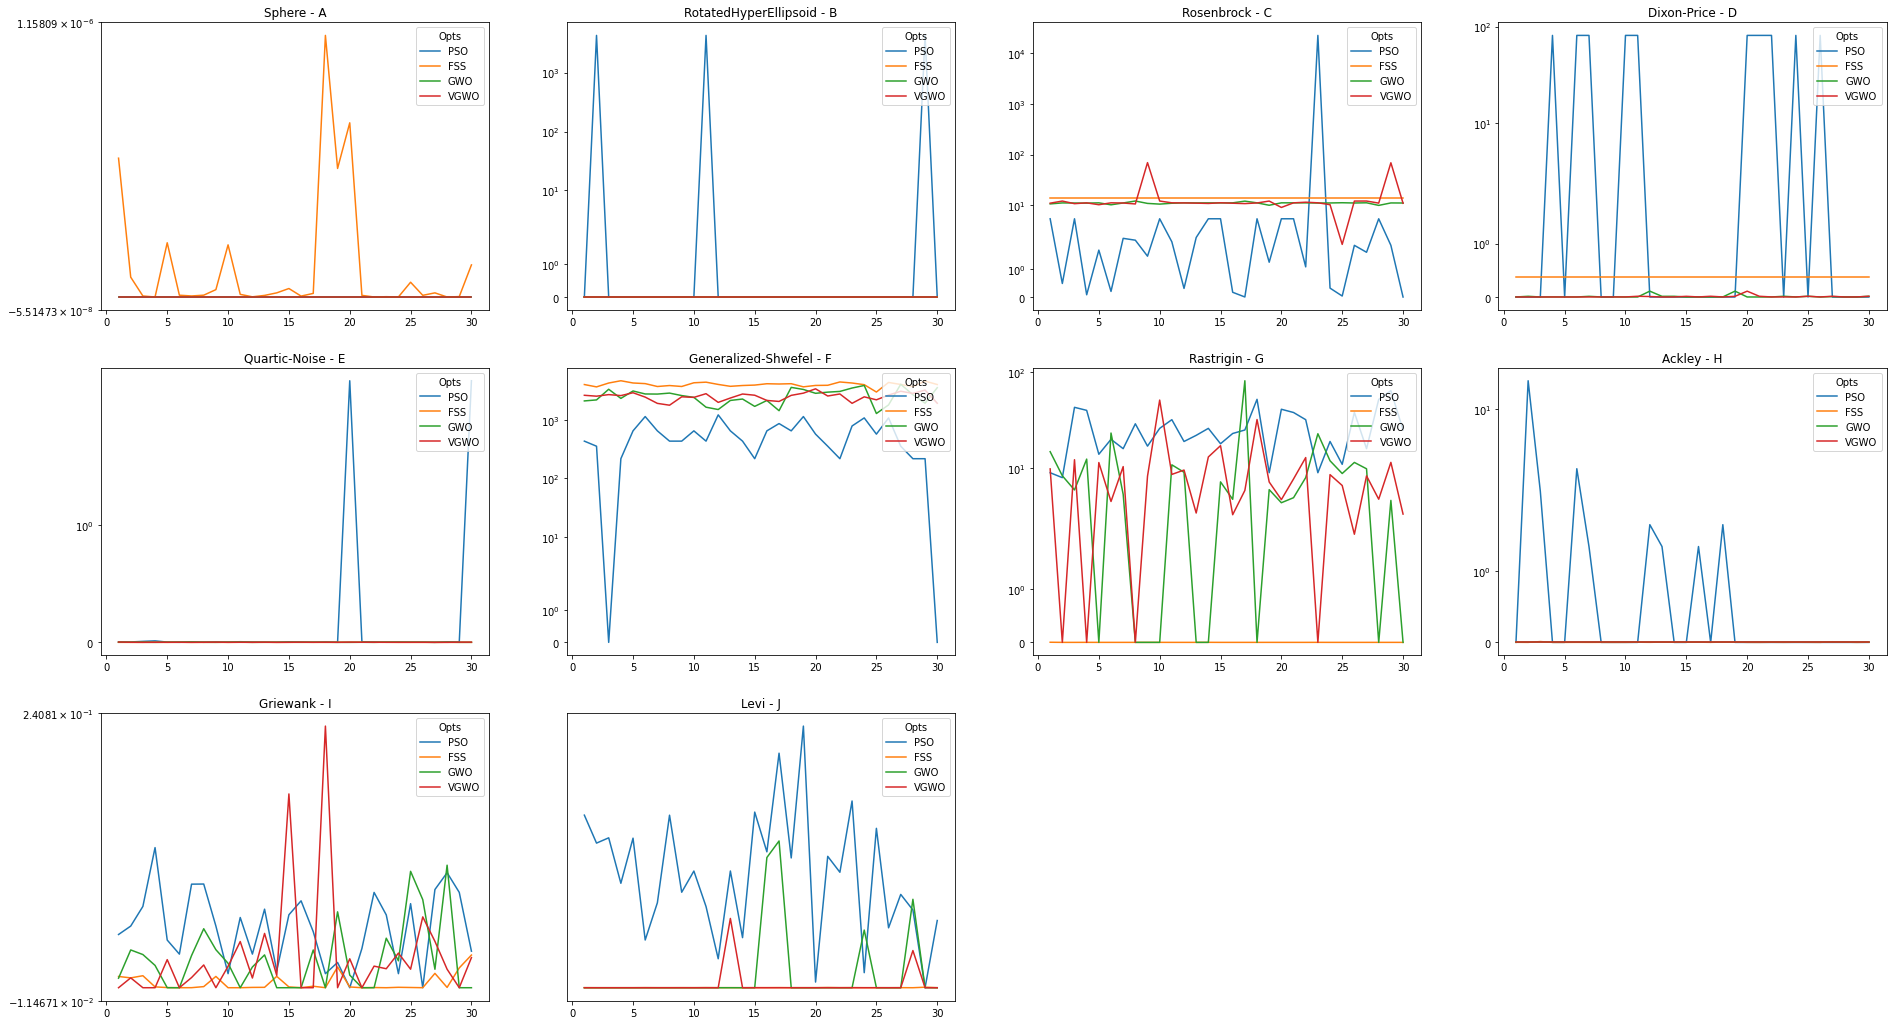

Functions w/ 30 dim


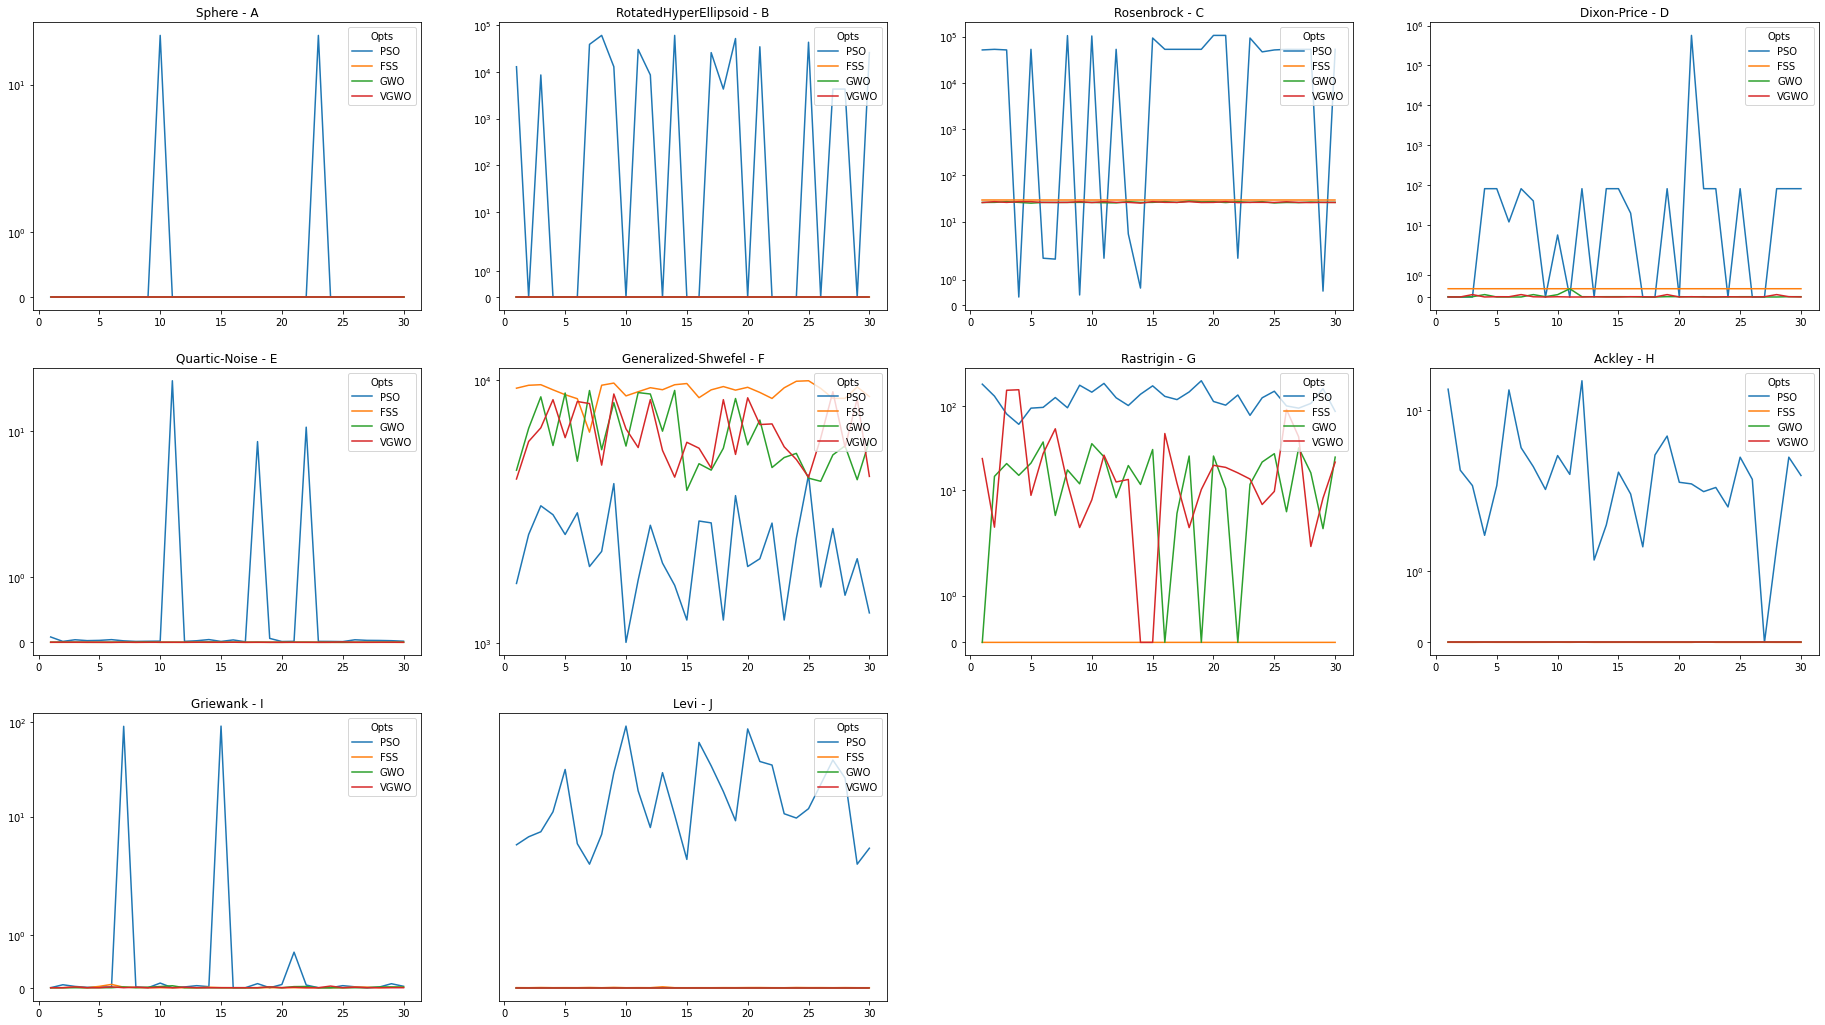

Functions w/ 50 dim


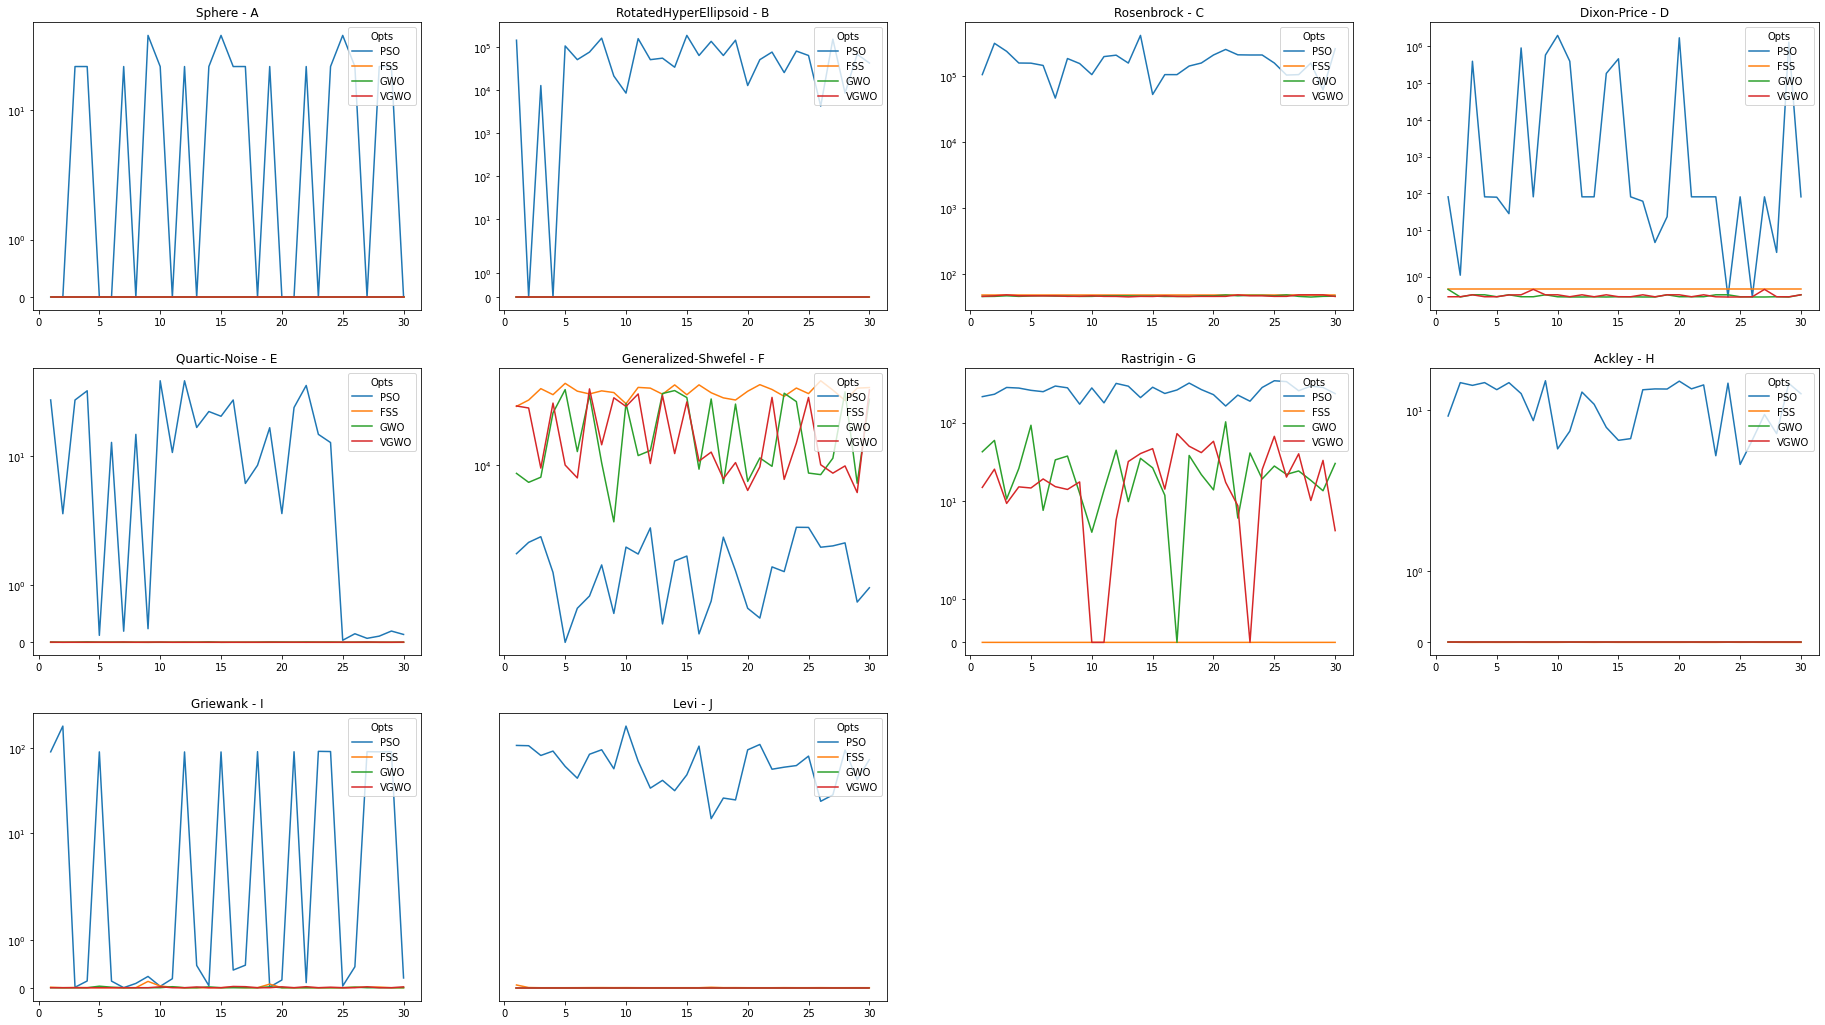

Functions w/ 100 dim


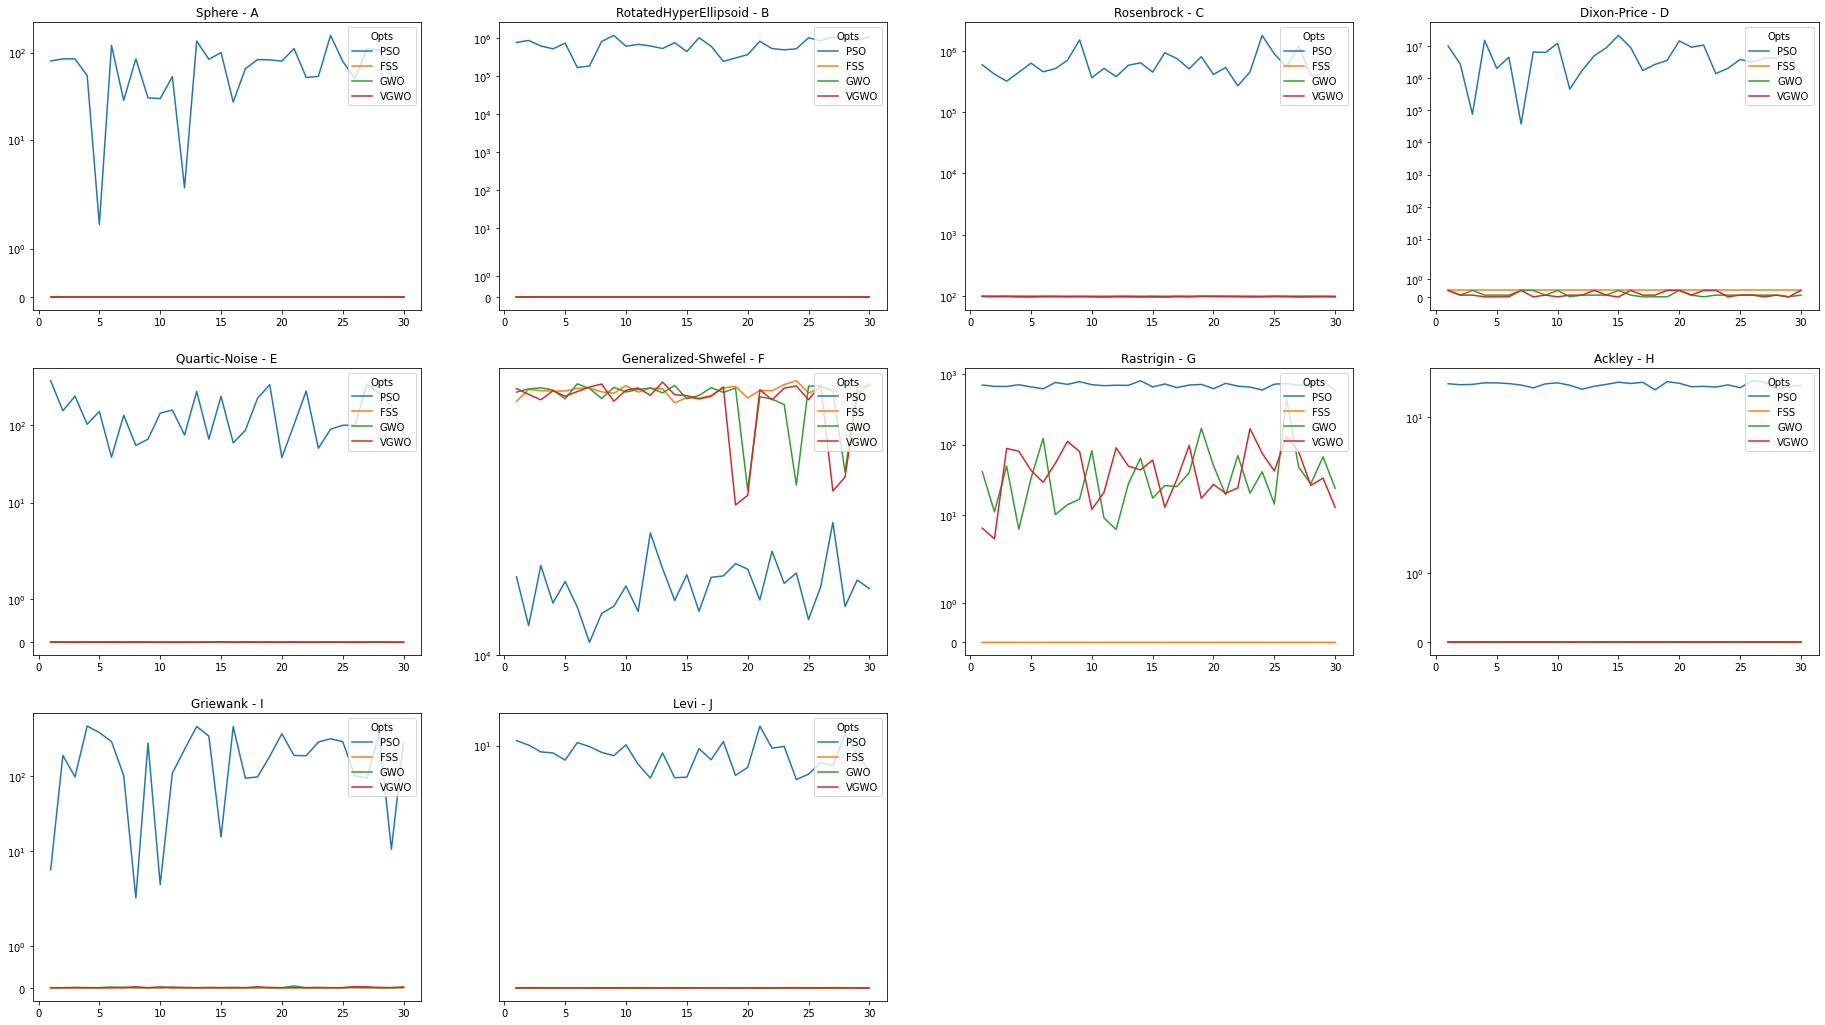

In [4]:
plt.rcParams["figure.figsize"] = (32,18)
tb_dt = {}
for d in results:
  tb_dt[d] = {}
  objective_functions = results[d]['func'].unique().tolist()
  # objective_functions.remove('Levi-13')
  # objective_functions.remove('Perm')
  opts = results[d]['opt'].unique()
  print(f"Functions w/ {d} dim")
  for i, func in enumerate(objective_functions):
    tb_dt[d][func] = {}
    plt.subplot(3, 4, i+1)
    for o in opts:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == o].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      y = res.values.tolist()[0]
      y = [v if v < 999e+999 else 999e+999 for v in y]
      tb_dt[d][func][o] = y
      dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
      plt.plot(dt, label=o)
      plt.yscale('symlog')
      plt.legend(loc='upper right', title='Opts')
    plt.title(f"{func} - {string.ascii_uppercase[i]}")
  plt.show()

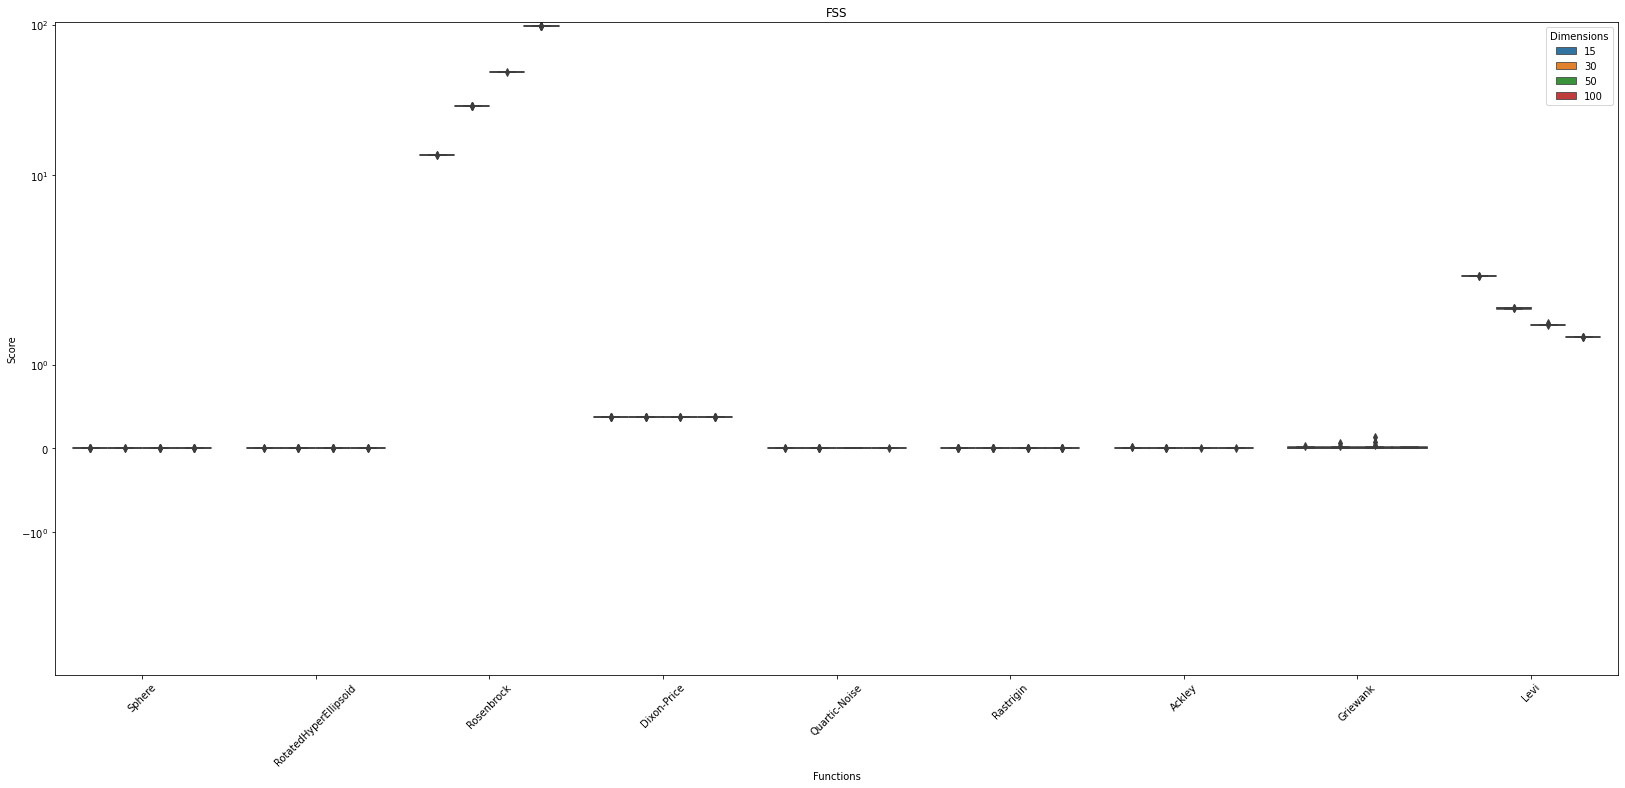

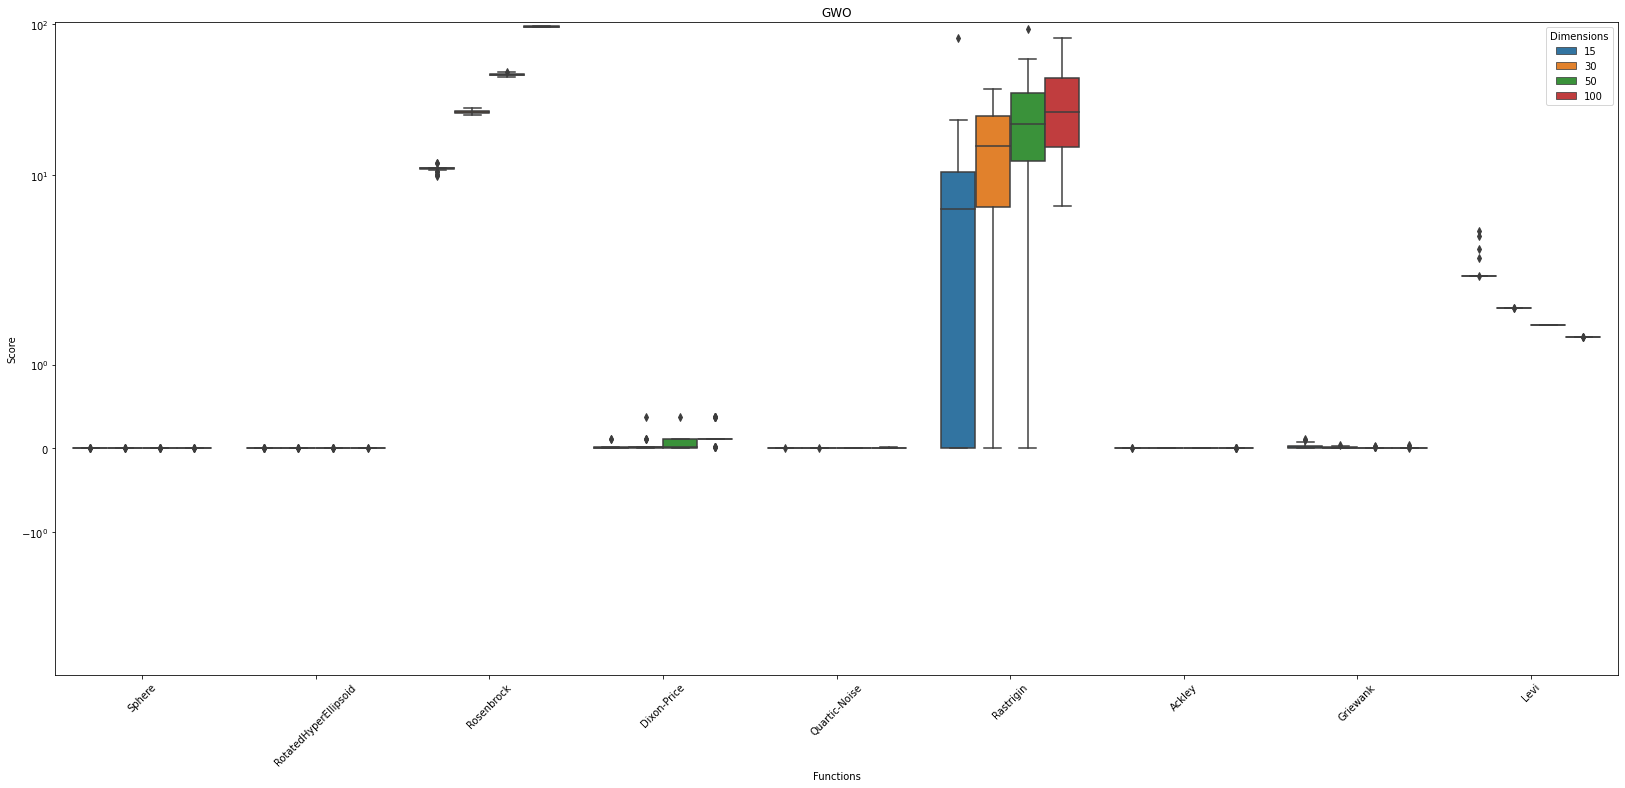

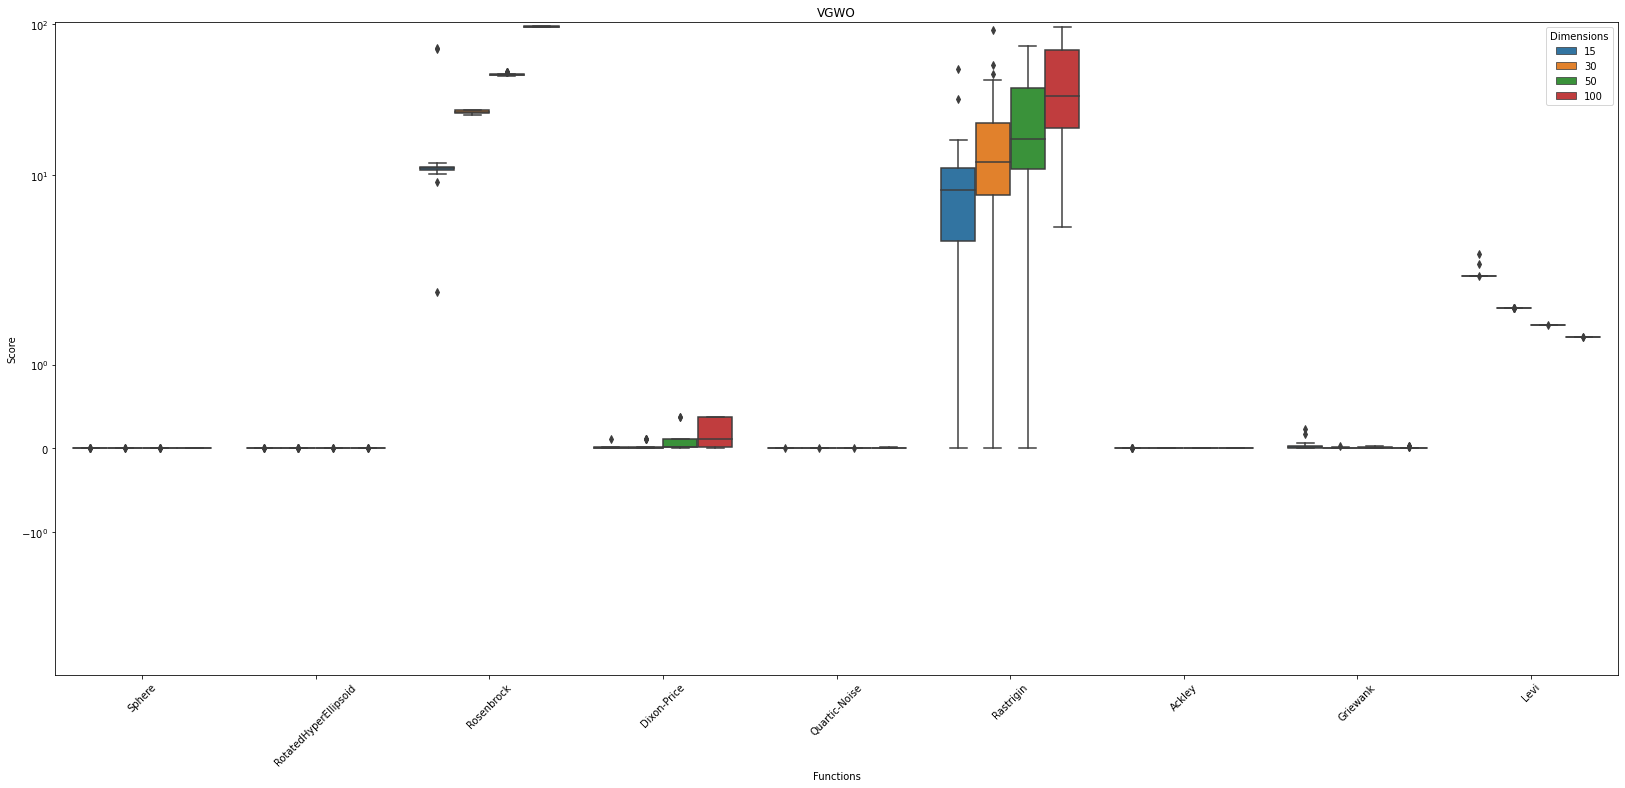

In [5]:
plt.rcParams["figure.figsize"] = (28,12)
for opt in opts[1:]:
  obj_show = []
  for d in results:
    objective_functions = results[d]['func'].unique().tolist()
    # objective_functions.remove('Levi-13')
    # objective_functions.remove('Perm')
    # objective_functions.remove('Perm')
    for func in objective_functions:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == opt].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      scores = res.values.tolist()[0]
      for s in scores:
        obj_show.append({'func': func, 'score': s, 'dim': d})

  res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['func', 'score', 'dim'])
  res = res[res["score"] <= 100] # remove outliers
  ax = sns.boxplot(data=res, x='func', y='score', hue="dim")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set(xlabel='Functions', ylabel='Score', title=f"{opt}")
  plt.legend(loc='upper right', title='Dimensions')
  plt.yscale('symlog')
  plt.show()

In [6]:
dt_func = []
for d in tb_dt:
  for func in tb_dt[d]:
    if func in ['Perm', 'Levi-13']:
      continue
    print(f"{func} w/ {d} dim")
    opts = list(tb_dt[d][func].keys())
    size_tb = len(tb_dt[d][func]["VGWO"])
    lines = [[tb_dt[d][func][o][i] for o in opts] for i in range(size_tb)]
    dt = pd.DataFrame(data=lines, index=range(1, len(tb_dt[d][func][o])+1), columns=opts)
    dt_func.append(dt)

    wil_pso_vgwo = sts.wilcoxon(dt['PSO'].tolist(), dt['VGWO'].tolist())
    wil_fss_vgwo = sts.wilcoxon(dt['FSS'].tolist(), dt['VGWO'].tolist())
    wil_gwo_vgwo = sts.wilcoxon(dt['GWO'].tolist(), dt['VGWO'].tolist())
    print('PSO-VGWO', wil_fss_vgwo)
    print('FSS-VGWO', wil_fss_vgwo)
    print('GWO-VGWO', wil_gwo_vgwo)
    # print(dt.describe())
    display(dt.describe().loc[:].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))
    print()

    # display(dt)
    display(dt.loc[:].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))
# dt_func[1].loc[:5].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;')

Sphere w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=114.0, pvalue=0.014795424247745142)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000001,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.000001,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000


RotatedHyperEllipsoid w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=223.0, pvalue=0.8450804241615161)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,429.496730,0.000109,0.000000,0.000000
std,1310.517258,0.000465,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000001,0.000000,0.000000
50%,0.000000,0.000010,0.000000,0.000000
75%,0.000000,0.000045,0.000000,0.000000
max,4294.967296,0.002564,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000,0.000000
2,4294.967296,0.000000,0.000000,0.000000
3,0.000000,0.000001,0.000000,0.000000
4,0.000000,0.000002,0.000000,0.000000
5,0.000000,0.000001,0.000000,0.000000
6,0.000000,0.000005,0.000000,0.000000
7,0.000000,0.000012,0.000000,0.000000
8,0.000000,0.000009,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000


Rosenbrock w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=59.0, pvalue=0.00035888445044696013)
FSS-VGWO WilcoxonResult(statistic=59.0, pvalue=0.00035888445044696013)
GWO-VGWO WilcoxonResult(statistic=194.0, pvalue=0.4284300285458069)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,752.915067,13.771110,11.051924,14.693893
std,4110.737848,0.000000,0.449599,14.945316
min,0.000074,13.771110,9.959682,1.869368
25%,0.357676,13.771110,11.046317,10.898739
50%,1.835971,13.771110,11.133661,11.127781
75%,5.421191,13.771110,11.179527,11.433232
max,22517.835971,13.771111,12.143632,69.483734


,PSO,FSS,GWO,VGWO
1,5.421191,13.771110,10.655300,11.015147
2,0.481159,13.771110,11.143579,12.118887
3,5.421191,13.771110,11.084326,10.770307
4,0.080342,13.771110,11.035963,11.177411
5,1.666219,13.771111,11.178395,10.264291
6,0.199158,13.771110,10.223530,11.189442
7,2.227756,13.771110,11.118719,11.093002
8,2.048207,13.771110,12.143632,10.627010
9,1.450815,13.771110,10.896364,69.483734
10,5.421191,13.771110,10.556819,12.143037


Dixon-Price w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=209.0, pvalue=0.6288430020541073)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,27.000000,0.375000,0.011530,0.008370
std,38.836527,0.000000,0.027275,0.019929
min,0.000000,0.375000,0.000196,0.000388
25%,0.000000,0.375000,0.000941,0.000961
50%,0.000000,0.375000,0.001588,0.001496
75%,81.000000,0.375000,0.012864,0.013015
max,81.000000,0.375000,0.110020,0.109484


,PSO,FSS,GWO,VGWO
1,0.000000,0.375000,0.001078,0.000723
2,0.000000,0.375000,0.013602,0.000388
3,0.000000,0.375000,0.000566,0.000861
4,81.000000,0.375000,0.001760,0.000956
5,0.000000,0.375000,0.001238,0.000457
6,81.000000,0.375000,0.001031,0.000701
7,81.000000,0.375000,0.012886,0.001528
8,0.000000,0.375000,0.001526,0.001331
9,0.000000,0.375000,0.002237,0.001440
10,81.000000,0.375000,0.000588,0.001276


Quartic-Noise w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=18.0, pvalue=1.0246327832617613e-05)
FSS-VGWO WilcoxonResult(statistic=18.0, pvalue=1.0246327832617613e-05)
GWO-VGWO WilcoxonResult(statistic=225.0, pvalue=0.8774027283940786)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.182569,0.000369,0.001054,0.001046
std,0.681432,0.000310,0.000692,0.000628
min,0.000554,0.000031,0.000239,0.000273
25%,0.001877,0.000134,0.000473,0.000666
50%,0.003225,0.000280,0.000976,0.000835
75%,0.004526,0.000512,0.001411,0.001406
max,2.689498,0.001216,0.003414,0.002883


,PSO,FSS,GWO,VGWO
1,0.003038,0.000258,0.001656,0.002883
2,0.003696,0.000146,0.000979,0.000939
3,0.008589,0.000252,0.001377,0.000323
4,0.012897,0.000241,0.000373,0.001149
5,0.002554,0.000123,0.001423,0.000754
6,0.004128,0.001161,0.000539,0.000714
7,0.003910,0.000114,0.003414,0.000273
8,0.003173,0.000303,0.000698,0.000858
9,0.003903,0.000396,0.000415,0.001947
10,0.002782,0.000043,0.001676,0.000578


Generalized-Shwefel w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=220.0, pvalue=0.7970983030067952)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,557.335773,4062.332929,2612.886432,2542.052902
std,337.112682,339.914792,759.897874,404.147271
min,0.000191,3013.131722,1291.348499,1792.125533
25%,355.348096,3893.226515,2131.150100,2257.644506
50%,503.383648,4055.709475,2663.441799,2597.273759
75%,651.419199,4300.116592,3127.058958,2789.898722
max,1223.906774,4702.891699,4093.377046,3420.201315


,PSO,FSS,GWO,VGWO
1,434.279530,4049.624961,2121.628565,2650.524117
2,355.348096,3690.415190,2208.193054,2557.935730
3,0.000191,4298.399222,3360.817609,2721.870513
4,217.139860,4702.891699,2344.389908,2618.066413
5,651.419199,4305.519653,3140.492549,2929.445390
6,1144.975340,4199.582404,2791.398689,2465.482669
7,651.419199,3747.070740,2780.449548,1926.181345
8,434.279530,3891.890620,2889.618295,1792.125533
9,434.279530,3750.323305,2620.237831,2494.892245
10,651.419199,4341.161601,2440.874598,2439.932590


Rastrigin w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=10.0, pvalue=4.729202337447058e-06)
FSS-VGWO WilcoxonResult(statistic=10.0, pvalue=4.729202337447058e-06)
GWO-VGWO WilcoxonResult(statistic=201.0, pvalue=0.517047890994101)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,26.309470,0.000182,9.171292,9.259795
std,14.249298,0.000469,14.910801,10.083528
min,7.959667,0.000000,0.000000,0.000000
25%,16.168070,0.000002,0.000000,3.687323
50%,23.878975,0.000012,5.951076,7.977291
75%,36.315789,0.000084,10.571458,11.156443
max,63.748022,0.002428,80.795976,50.887363


,PSO,FSS,GWO,VGWO
1,8.954626,0.002428,14.811950,9.815959
2,7.959667,0.000002,8.324958,0.000000
3,42.783073,0.000057,5.929194,12.222666
4,39.798094,0.000549,12.401229,0.000000
5,13.929417,0.000113,0.000000,11.419841
6,19.899146,0.000001,23.135696,4.502157
7,15.919330,0.000000,5.342543,10.366250
8,28.853747,0.000084,0.000000,0.000000
9,16.914289,0.000011,0.000000,8.240744
10,25.868885,0.000333,0.000000,50.887363


Ackley w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=11.0, pvalue=0.30464192203660967)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.992998,0.001871,0.000000,0.000000
std,3.093094,0.002567,0.000000,0.000000
min,0.000000,0.000029,0.000000,0.000000
25%,0.000000,0.000250,0.000000,0.000000
50%,0.000000,0.000919,0.000000,0.000000
75%,1.005316,0.002240,0.000000,0.000000
max,16.699717,0.011242,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.001077,0.000000,0.000000
2,16.699717,0.000032,0.000000,0.000000
3,2.315468,0.011242,0.000000,0.000000
4,0.000000,0.000029,0.000000,0.000000
5,0.000000,0.000036,0.000000,0.000000
6,3.461048,0.000529,0.000000,0.000000
7,1.340421,0.000069,0.000000,0.000000
8,0.000000,0.000495,0.000000,0.000000
9,0.000000,0.000143,0.000000,0.000000
10,0.000000,0.000388,0.000000,0.000000


Griewank w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=98.0, pvalue=0.0056671726914977955)
FSS-VGWO WilcoxonResult(statistic=98.0, pvalue=0.0056671726914977955)
GWO-VGWO WilcoxonResult(statistic=144.0, pvalue=0.42368977533956986)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,0.052756,0.004396,0.025072,0.028007
std,0.032119,0.007231,0.029931,0.049983
min,0.000000,0.000000,0.000000,0.000000
25%,0.029465,0.000034,0.000000,0.000000
50%,0.054041,0.000353,0.018863,0.016227
75%,0.075554,0.009554,0.033100,0.026116
max,0.122815,0.028640,0.107404,0.229343


,PSO,FSS,GWO,VGWO
1,0.046664,0.009866,0.008355,0.000000
2,0.054033,0.008621,0.033108,0.008642
3,0.071271,0.010516,0.029082,0.000000
4,0.122815,0.000729,0.019557,0.000000
5,0.041780,0.000130,0.000000,0.024614
6,0.029459,0.000000,0.000000,0.000000
7,0.090782,0.000040,0.028216,0.008896
8,0.090890,0.000965,0.051695,0.019939
9,0.054050,0.009899,0.033319,0.000000
10,0.012316,0.000004,0.021405,0.018766


Levi w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=59.0, pvalue=0.00035888445044696013)
FSS-VGWO WilcoxonResult(statistic=59.0, pvalue=0.00035888445044696013)
GWO-VGWO WilcoxonResult(statistic=6.5, pvalue=0.2040841777655732)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,3.818839,2.160468,2.350981,2.201174
std,1.197967,0.000975,0.539930,0.166568
min,2.159845,2.159846,2.159845,2.159845
25%,2.997128,2.159953,2.159845,2.159845
50%,3.721660,2.160190,2.159845,2.159845
75%,4.359493,2.160498,2.159845,2.159845
max,7.363660,2.164999,4.297476,2.988587


,PSO,FSS,GWO,VGWO
1,4.850613,2.160269,2.159845,2.159845
2,4.254474,2.159899,2.159845,2.159845
3,4.361283,2.159881,2.159845,2.159845
4,3.524232,2.159876,2.159845,2.159845
5,4.354124,2.159924,2.159845,2.159845
6,2.701337,2.160723,2.159845,2.159845
7,3.216356,2.160074,2.159845,2.159845
8,4.849358,2.160038,2.159845,2.159845
9,3.379322,2.160429,2.159845,2.159845
10,3.732212,2.160121,2.159845,2.159845


Sphere w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=103.0, pvalue=0.007730944211317755)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,1.747627,0.000000,0.000000,0.000000
std,6.650806,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,26.214400,0.000000,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
10,26.214400,0.000000,0.000000,0.000000


RotatedHyperEllipsoid w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=104.0, pvalue=0.008216736457590426)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,14173.392077,0.000084,0.000000,0.000000
std,19605.916985,0.000170,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000003,0.000000,0.000000
50%,4294.967296,0.000014,0.000000,0.000000
75%,25769.803776,0.000040,0.000000,0.000000
max,60129.542144,0.000682,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,12884.901888,0.000000,0.000000,0.000000
2,0.000000,0.000002,0.000000,0.000000
3,8589.934592,0.000012,0.000000,0.000000
4,0.000000,0.000016,0.000000,0.000000
5,0.000000,0.000001,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,38654.705664,0.000395,0.000000,0.000000
8,60129.542144,0.000034,0.000000,0.000000
9,12884.901888,0.000024,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000


Rosenbrock w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=220.0, pvalue=0.7970983030067952)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,46321.053051,28.771110,26.264920,26.301957
std,36196.010971,0.000001,0.610190,0.522926
min,0.326282,28.771110,25.131059,25.161712
25%,2.732276,28.771110,25.999891,26.010747
50%,52992.827587,28.771110,26.089913,26.099706
75%,53001.132448,28.771110,26.758181,26.978204
max,105990.812400,28.771115,27.883426,27.087552


,PSO,FSS,GWO,VGWO
1,51417.604155,28.771110,26.000310,25.887538
2,53002.956378,28.771110,26.106644,27.058220
3,51417.604155,28.771110,27.044796,26.074399
4,0.326282,28.771110,26.095757,27.062133
5,53000.348257,28.771110,25.131059,27.031565
6,1.835971,28.771110,26.084069,26.060955
7,1.801133,28.771110,25.964822,26.057470
8,104869.839942,28.771110,26.042714,26.107011
9,0.406118,28.771110,26.123630,27.065491
10,103012.723128,28.771115,26.078474,25.864245


Dixon-Price w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=183.0, pvalue=0.30861485052601767)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,18985.479068,0.375000,0.031573,0.020592
std,103774.307445,0.000001,0.071830,0.036152
min,0.000000,0.375000,0.001620,0.000420
25%,0.000007,0.375000,0.002671,0.001923
50%,29.854354,0.375000,0.014191,0.006825
75%,81.000000,0.375000,0.015049,0.014417
max,568434.221957,0.375005,0.375001,0.110305


,PSO,FSS,GWO,VGWO
1,0.000000,0.375000,0.013827,0.001976
2,0.000000,0.375000,0.001949,0.003158
3,0.000535,0.375000,0.014341,0.110031
4,81.000000,0.375000,0.109923,0.002394
5,81.000000,0.375000,0.001868,0.013973
6,11.857257,0.375000,0.002123,0.012253
7,81.000000,0.375000,0.001802,0.110305
8,40.002877,0.375000,0.109896,0.010491
9,0.000000,0.375000,0.014293,0.001922
10,5.579936,0.375000,0.107458,0.012133


Quartic-Noise w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=7.0, pvalue=3.5152372790448263e-06)
FSS-VGWO WilcoxonResult(statistic=7.0, pvalue=3.5152372790448263e-06)
GWO-VGWO WilcoxonResult(statistic=153.0, pvalue=0.1020106952499886)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,1.548090,0.000450,0.002011,0.001813
std,5.352045,0.000511,0.001034,0.001052
min,0.009178,0.000017,0.000451,0.000600
25%,0.015259,0.000169,0.001364,0.001070
50%,0.025482,0.000254,0.001722,0.001726
75%,0.040182,0.000461,0.002588,0.002203
max,26.857521,0.002277,0.005774,0.006281


,PSO,FSS,GWO,VGWO
1,0.083245,0.000065,0.001654,0.002003
2,0.014859,0.000219,0.002855,0.002808
3,0.040289,0.000376,0.002608,0.002197
4,0.026841,0.000066,0.001186,0.002108
5,0.030725,0.000169,0.001166,0.001452
6,0.042191,0.000143,0.001601,0.000600
7,0.023553,0.000470,0.002723,0.002814
8,0.014683,0.000269,0.001547,0.000977
9,0.017036,0.000910,0.004017,0.001814
10,0.018913,0.000651,0.000914,0.002234


Generalized-Shwefel w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=12.0, pvalue=5.751653269401829e-06)
FSS-VGWO WilcoxonResult(statistic=12.0, pvalue=5.751653269401829e-06)
GWO-VGWO WilcoxonResult(statistic=214.0, pvalue=0.7035636998700077)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,2330.889801,9081.542294,6158.333494,6365.406414
std,863.842290,675.822942,1761.716237,1589.246254
min,1006.767295,6328.786900,3803.211204,4201.470234
25%,1664.957421,8713.218228,4828.598203,5254.993658
50%,2161.569760,9225.650531,5608.600251,5922.082591
75%,2861.161290,9508.481668,7903.000914,8235.364785
max,4350.223610,9920.369557,9116.744389,9011.758425


,PSO,FSS,GWO,VGWO
1,1685.270775,9295.089607,4536.897894,4201.470234
2,2586.021784,9535.226352,6543.111028,5834.026238
3,3323.802065,9582.931299,8619.318346,6573.156519
4,3074.470064,9162.963811,5628.792516,8408.068027
5,2586.021784,8781.897173,8912.325938,6031.209015
6,3126.317027,8477.497110,4906.887217,8271.593410
7,1954.257406,6328.786900,9108.811488,8126.678912
8,2230.673878,9538.418179,5428.782578,4743.288235
9,4034.910754,9721.258305,8192.012424,8835.966949
10,1006.767295,8690.325247,5603.278126,6511.577640


Rastrigin w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=3.0, pvalue=2.3534209951215346e-06)
FSS-VGWO WilcoxonResult(statistic=3.0, pvalue=2.3534209951215346e-06)
GWO-VGWO WilcoxonResult(statistic=224.0, pvalue=0.8612125197358381)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,125.662759,0.000059,16.083514,27.553556
std,35.498059,0.000124,11.045974,39.619655
min,60.692341,0.000000,0.000000,0.000000
25%,97.558889,0.000001,6.193800,7.762566
50%,125.506517,0.000009,15.541012,12.965114
75%,147.093377,0.000033,24.876420,25.508121
max,200.198902,0.000550,37.456513,156.453874


,PSO,FSS,GWO,VGWO
1,182.289882,0.000000,0.000000,23.758717
2,131.333983,0.000003,14.597069,3.630614
3,80.591456,0.000004,20.725124,154.228815
4,60.692341,0.000550,15.016065,156.453874
5,94.520787,0.000000,20.980692,8.680939
6,96.581723,0.000092,37.456513,27.217545
7,126.430246,0.000071,4.999678,53.735700
8,95.515685,0.000001,17.428461,12.064175
9,177.172753,0.000001,11.893972,3.596272
10,146.400348,0.000199,35.732016,7.670479


Ackley w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=66.5, pvalue=0.24165970194183828)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,4.101776,0.000654,0.000000,0.000000
std,4.023858,0.001197,0.000000,0.000000
min,0.000000,0.000021,0.000000,0.000000
25%,2.244125,0.000158,0.000000,0.000000
50%,2.812682,0.000273,0.000000,0.000000
75%,4.297406,0.000612,0.000000,0.000000
max,16.938867,0.006341,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,14.560640,0.000787,0.000000,0.000000
2,3.403236,0.000421,0.000000,0.000000
3,2.579928,0.000147,0.000000,0.000000
4,1.501747,0.001210,0.000000,0.000000
5,2.579535,0.000449,0.000000,0.000000
6,14.369470,0.000491,0.000000,0.000000
7,5.089648,0.000221,0.000000,0.000000
8,3.628007,0.000529,0.000000,0.000000
9,2.407752,0.000742,0.000000,0.000000
10,4.423332,0.001371,0.000000,0.000000


Griewank w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=157.0, pvalue=0.12044472790832522)
FSS-VGWO WilcoxonResult(statistic=157.0, pvalue=0.12044472790832522)
GWO-VGWO WilcoxonResult(statistic=52.0, pvalue=0.40804420568711997)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,6.087387,0.005577,0.006124,0.004274
std,22.985635,0.012374,0.009884,0.007621
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000004,0.000000,0.000000
50%,0.015999,0.000164,0.000000,0.000000
75%,0.055213,0.009281,0.012874,0.009295
max,90.891061,0.062950,0.037458,0.031374


,PSO,FSS,GWO,VGWO
1,0.000000,0.000000,0.000000,0.000000
2,0.056508,0.000320,0.000000,0.000000
3,0.024573,0.009875,0.000000,0.015613
4,0.007396,0.000007,0.000000,0.000000
5,0.014772,0.025900,0.000000,0.000000
6,0.012321,0.062950,0.000000,0.016279
7,90.398300,0.010120,0.015127,0.000000
8,0.014772,0.004228,0.000000,0.010231
9,0.000000,0.000236,0.010193,0.000000
10,0.088305,0.000002,0.022512,0.009202


Levi w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=73.0, pvalue=0.5821260941167519)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,4.590145,1.669549,1.668971,1.668971
std,1.224299,0.000906,0.000000,0.000000
min,2.946845,1.668978,1.668971,1.668971
25%,3.598896,1.669073,1.668971,1.668971
50%,4.198836,1.669228,1.668971,1.668971
75%,5.459003,1.669612,1.668971,1.668971
max,7.294093,1.673730,1.668971,1.668971


,PSO,FSS,GWO,VGWO
1,3.346372,1.669403,1.668971,1.668971
2,3.526883,1.669034,1.668971,1.668971
3,3.645249,1.670092,1.668971,1.668971
4,4.156026,1.669181,1.668971,1.668971
5,5.486658,1.669393,1.668971,1.668971
6,3.370266,1.669167,1.668971,1.668971
7,2.946940,1.670293,1.668971,1.668971
8,3.583445,1.669000,1.668971,1.668971
9,5.376038,1.670754,1.668971,1.668971
10,7.294093,1.669032,1.668971,1.668971


Sphere w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=118.0, pvalue=0.018518974697467713)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,17.476710,0.000000,0.000000,0.000000
std,17.324719,0.000000,0.000000,0.000000
min,0.000001,0.000000,0.000000,0.000000
25%,0.000025,0.000000,0.000000,0.000000
50%,26.214401,0.000000,0.000000,0.000000
75%,26.214451,0.000000,0.000000,0.000000
max,52.428880,0.000000,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,0.000004,0.000000,0.000000,0.000000
2,0.000001,0.000000,0.000000,0.000000
3,26.217073,0.000000,0.000000,0.000000
4,26.214401,0.000000,0.000000,0.000000
5,0.000496,0.000000,0.000000,0.000000
6,0.000023,0.000000,0.000000,0.000000
7,26.214462,0.000000,0.000000,0.000000
8,0.000015,0.000000,0.000000,0.000000
9,52.428880,0.000000,0.000000,0.000000
10,26.214400,0.000000,0.000000,0.000000


RotatedHyperEllipsoid w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=85.0, pvalue=0.0024147041360347552)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,69435.701304,0.000113,0.000000,0.000000
std,56159.023985,0.000244,0.000000,0.000000
min,0.000737,0.000000,0.000000,0.000000
25%,22548.582077,0.000003,0.000000,0.000000
50%,60129.635546,0.000008,0.000000,0.000000
75%,100931.788510,0.000053,0.000000,0.000000
max,188978.586052,0.000898,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,146028.888191,0.000000,0.000000,0.000000
2,0.006998,0.000041,0.000000,0.000000
3,12884.954179,0.000000,0.000000,0.000000
4,0.000737,0.000011,0.000000,0.000000
5,107374.258446,0.000000,0.000000,0.000000
6,51539.688835,0.000060,0.000000,0.000000
7,77309.412122,0.000003,0.000000,0.000000
8,163208.780294,0.000010,0.000000,0.000000
9,21474.841119,0.000589,0.000000,0.000000
10,8589.997471,0.000001,0.000000,0.000000


Rosenbrock w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=230.0, pvalue=0.958990172136891)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,170665.191822,48.771110,46.610567,46.677617
std,78676.769642,0.000000,0.765380,0.972185
min,46696.890043,48.771110,44.989831,45.190762
25%,106004.116230,48.771110,46.016361,46.010256
50%,158826.575256,48.771110,46.517173,46.116203
75%,210306.036279,48.771110,46.969136,46.963164
max,416838.534063,48.771111,48.474212,48.573249


,PSO,FSS,GWO,VGWO
1,106001.630125,48.771110,45.810918,46.040047
2,316262.491505,48.771110,46.010828,46.936485
3,238992.024350,48.771110,46.986039,48.573249
4,158958.553677,48.771111,46.033474,46.966664
5,158156.871441,48.771110,46.647427,46.997237
6,145971.361434,48.771110,46.984274,46.874904
7,46696.890043,48.771110,46.461024,46.878782
8,185860.673461,48.771110,46.539600,46.066067
9,156011.874577,48.771110,45.973529,46.166339
10,106003.252612,48.771110,46.032958,46.984831


Dixon-Price w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=2.0, pvalue=2.1266360107314253e-06)
FSS-VGWO WilcoxonResult(statistic=2.0, pvalue=2.1266360107314253e-06)
GWO-VGWO WilcoxonResult(statistic=157.0, pvalue=0.12044472790832522)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,257897.919828,0.375000,0.048725,0.075503
std,518873.519838,0.000000,0.076368,0.094044
min,0.014675,0.375000,0.002534,0.001279
25%,65.986244,0.375000,0.004046,0.014371
50%,81.000522,0.375000,0.015001,0.016032
75%,334366.716089,0.375000,0.109920,0.110095
max,1939174.753634,0.375001,0.375002,0.375003


,PSO,FSS,GWO,VGWO
1,81.002003,0.375001,0.375002,0.014334
2,1.067611,0.375000,0.003834,0.015114
3,385795.285727,0.375000,0.110190,0.109864
4,81.008654,0.375000,0.110270,0.014882
5,79.248035,0.375000,0.015475,0.014700
6,28.306626,0.375000,0.110177,0.102804
7,886091.481173,0.375000,0.014348,0.110133
8,81.000732,0.375000,0.014652,0.374999
9,568434.223323,0.375000,0.110218,0.107360
10,1939174.753634,0.375000,0.013104,0.110204


Quartic-Noise w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=190.0, pvalue=0.38203416302245696)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,17.118641,0.000372,0.003616,0.003138
std,17.528618,0.000234,0.001766,0.001127
min,0.036863,0.000021,0.001312,0.001387
25%,0.208168,0.000191,0.002279,0.002424
50%,13.536720,0.000327,0.003317,0.002872
75%,28.964037,0.000494,0.004644,0.003803
max,53.839351,0.000896,0.007593,0.005939


,PSO,FSS,GWO,VGWO
1,35.045203,0.000160,0.004972,0.004490
2,2.750288,0.000896,0.002262,0.001387
3,34.985533,0.000764,0.003223,0.002643
4,42.997878,0.000268,0.007593,0.002925
5,0.122767,0.000446,0.003430,0.003717
6,13.559738,0.000212,0.004653,0.002454
7,0.195289,0.000265,0.003233,0.005939
8,16.226934,0.000364,0.002460,0.001975
9,0.238778,0.000269,0.001416,0.003787
10,53.839351,0.000732,0.002901,0.004871


Generalized-Shwefel w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=7.0, pvalue=3.5152372790448263e-06)
FSS-VGWO WilcoxonResult(statistic=7.0, pvalue=3.5152372790448263e-06)
GWO-VGWO WilcoxonResult(statistic=229.0, pvalue=0.9426105124576512)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,5005.220314,16289.676076,12245.144384,12186.044807
std,1075.047143,658.434461,3172.653930,2917.802837
min,3080.062004,14798.015718,6864.913188,8341.157551
25%,4033.856101,15988.244282,9480.818979,9911.662949
50%,5121.567110,16364.482293,10810.392008,10861.635996
75%,5838.966743,16710.332003,15534.002125,15212.228690
max,6620.973990,17543.215563,16538.638946,16618.709580


,PSO,FSS,GWO,VGWO
1,5554.900514,14798.015718,9475.837085,14833.998815
2,5988.964332,15429.361757,8926.905340,14635.187249
3,6218.846239,16644.778894,9237.235691,9816.007738
4,4903.060132,15992.283110,14162.660545,15121.854865
5,3080.062004,17241.982986,16538.638946,10014.026005
6,3864.097689,16369.369957,10954.031980,9195.994568
7,4192.361219,16069.089203,15948.136943,16618.709580
8,5155.126871,16403.013577,10164.284859,11460.210038
9,3733.586784,16218.168705,6864.913188,15664.611114
10,5804.223780,15060.378493,15086.727605,14790.301706


Rastrigin w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=6.0, pvalue=3.181679410969855e-06)
FSS-VGWO WilcoxonResult(statistic=6.0, pvalue=3.181679410969855e-06)
GWO-VGWO WilcoxonResult(statistic=215.0, pvalue=0.7188875621362669)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,257.690940,0.000074,28.138137,24.326862
std,46.819010,0.000253,23.420674,19.664668
min,163.173590,0.000000,0.000000,0.000000
25%,228.661732,0.000000,12.733036,11.072461
50%,263.271951,0.000005,22.951021,17.343598
75%,283.242087,0.000030,36.775855,38.192100
max,343.401517,0.001378,102.424370,72.377120


,PSO,FSS,GWO,VGWO
1,214.981552,0.000032,42.417072,14.849073
2,230.900774,0.000000,59.305471,25.398502
3,281.785168,0.000034,10.530858,9.266635
4,276.882711,0.000002,25.897985,15.084868
5,258.972393,0.000000,92.620446,14.604437
6,248.809952,0.000014,7.555381,19.049313
7,293.866575,0.000007,33.414081,15.197118
8,278.800252,0.000006,37.385718,13.985583
9,172.198348,0.000000,12.489718,17.450189
10,277.821711,0.000169,3.967014,0.000000


Ackley w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=79.0, pvalue=0.7729116533658063)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,11.599355,0.000549,0.000000,0.000000
std,4.524560,0.000798,0.000000,0.000000
min,3.763376,0.000002,0.000000,0.000000
25%,6.952615,0.000080,0.000000,0.000000
50%,13.594093,0.000186,0.000000,0.000000
75%,15.629532,0.000761,0.000000,0.000000
max,16.876775,0.003884,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,8.963861,0.003884,0.000000,0.000000
2,16.315536,0.000727,0.000000,0.000000
3,15.535698,0.000079,0.000000,0.000000
4,16.323590,0.000527,0.000000,0.000000
5,14.381725,0.000002,0.000000,0.000000
6,16.311906,0.000170,0.000000,0.000000
7,13.409972,0.000882,0.000000,0.000000
8,8.254008,0.000051,0.000000,0.000000
9,16.876775,0.000176,0.000000,0.000000
10,4.975514,0.000193,0.000000,0.000000


Griewank w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=187.0, pvalue=0.34934556237492975)
FSS-VGWO WilcoxonResult(statistic=187.0, pvalue=0.34934556237492975)
GWO-VGWO WilcoxonResult(statistic=46.0, pvalue=0.42652824883677154)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,39.335529,0.010661,0.003790,0.005767
std,51.359900,0.027626,0.008363,0.009251
min,0.001188,0.000000,0.000000,0.000000
25%,0.115368,0.000035,0.000000,0.000000
50%,0.407304,0.000650,0.000000,0.000000
75%,90.282573,0.009891,0.000000,0.014601
max,180.929897,0.133461,0.032282,0.026359


,PSO,FSS,GWO,VGWO
1,90.276735,0.009898,0.000000,0.000000
2,180.929897,0.000262,0.000000,0.000000
3,0.009541,0.004242,0.000000,0.000000
4,0.142149,0.001569,0.000000,0.000000
5,90.171804,0.000853,0.032282,0.000000
6,0.139505,0.000005,0.011121,0.000000
7,0.001188,0.000000,0.000000,0.000000
8,0.090418,0.000106,0.000000,0.000000
9,0.238209,0.133461,0.000000,0.000000
10,0.029640,0.036312,0.000000,0.019307


Levi w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=85.5, pvalue=0.2925470119314686)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,6.210396,1.473556,1.472622,1.472622
std,1.049403,0.003168,0.000000,0.000000
min,4.045984,1.472631,1.472622,1.472622
25%,5.538696,1.472682,1.472622,1.472622
50%,6.217829,1.472781,1.472622,1.472622
75%,7.065094,1.473124,1.472622,1.472622
max,8.609305,1.490058,1.472622,1.472622


,PSO,FSS,GWO,VGWO
1,7.352935,1.490058,1.472622,1.472622
2,7.335697,1.473779,1.472622,1.472622
3,6.774688,1.472631,1.472622,1.472622
4,7.021436,1.472668,1.472622,1.472622
5,6.196829,1.472663,1.472622,1.472622
6,5.627149,1.472859,1.472622,1.472622
7,6.842079,1.473328,1.472622,1.472622
8,7.097512,1.473455,1.472622,1.472622
9,6.078288,1.473071,1.472622,1.472622
10,8.609305,1.473234,1.472622,1.472622


Sphere w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=40.0, pvalue=7.513662254944795e-05)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,71.238291,0.000000,0.000000,0.000000
std,37.037444,0.000000,0.000000,0.000000
min,1.501563,0.000000,0.000000,0.000000
25%,51.962998,0.000000,0.000000,0.000000
50%,79.561680,0.000000,0.000000,0.000000
75%,84.645965,0.000000,0.000000,0.000000
max,157.417452,0.000002,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,79.998041,0.000000,0.000000,0.000000
2,84.683056,0.000000,0.000000,0.000000
3,84.408963,0.000000,0.000000,0.000000
4,54.374409,0.000000,0.000000,0.000000
5,1.501563,0.000000,0.000000,0.000000
6,120.918696,0.000000,0.000000,0.000000
7,28.238350,0.000000,0.000000,0.000000
8,84.534694,0.000000,0.000000,0.000000
9,30.174691,0.000000,0.000000,0.000000
10,29.534451,0.000000,0.000000,0.000000


RotatedHyperEllipsoid w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=71.0, pvalue=0.0008944300647461546)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,667390.830247,0.000212,0.000000,0.000000
std,269559.722618,0.000574,0.000000,0.000000
min,167153.969397,0.000000,0.000000,0.000000
25%,515383.519625,0.000006,0.000000,0.000000
50%,645997.912291,0.000038,0.000000,0.000000
75%,853804.766813,0.000106,0.000000,0.000000
max,1162349.623668,0.002959,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,757631.421545,0.000036,0.000000,0.000000
2,857696.444813,0.000000,0.000000,0.000000
3,613581.104057,0.000028,0.000000,0.000000
4,514677.835047,0.000001,0.000000,0.000000
5,727923.210978,0.000752,0.000000,0.000000
6,167153.969397,0.000000,0.000000,0.000000
7,182307.553868,0.000225,0.000000,0.000000
8,804716.300944,0.000005,0.000000,0.000000
9,1162349.623668,0.000072,0.000000,0.000000
10,603055.299124,0.000016,0.000000,0.000000


Rosenbrock w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=208.0, pvalue=0.6143145637885868)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,641878.991172,98.771112,97.006924,97.066876
std,343608.670326,0.000009,0.853644,0.785816
min,267489.628092,98.771110,95.705939,95.659217
25%,425189.188644,98.771110,96.690159,96.606277
50%,525025.377993,98.771110,96.762512,96.856733
75%,733936.613747,98.771110,97.867653,97.605395
max,1782915.577003,98.771160,98.220685,98.210152


,PSO,FSS,GWO,VGWO
1,589938.778485,98.771110,97.527159,98.196091
2,415301.411928,98.771110,98.182690,96.735166
3,318757.620452,98.771110,97.488630,98.210152
4,446411.133602,98.771110,95.885856,97.621194
5,628802.044952,98.771110,95.837660,96.839538
6,453424.748654,98.771110,98.214303,96.589705
7,510769.617386,98.771110,98.011558,96.873929
8,699734.488899,98.771110,96.751030,96.702576
9,1503779.314325,98.771110,96.745765,97.518316
10,362927.133454,98.771110,96.802663,96.745671


Dixon-Price w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=45.0, pvalue=0.0001149921754357011)
FSS-VGWO WilcoxonResult(statistic=45.0, pvalue=0.0001149921754357011)
GWO-VGWO WilcoxonResult(statistic=229.0, pvalue=0.9426105124576512)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,5793371.769261,0.375000,0.153137,0.160779
std,5090295.505527,0.000000,0.129837,0.148337
min,37459.375366,0.375000,0.012378,0.003877
25%,2006569.463446,0.375000,0.109333,0.016208
50%,4200854.816797,0.375000,0.110416,0.110242
75%,8949353.953245,0.375000,0.110917,0.375004
max,21347813.130156,0.375000,0.375009,0.375011


,PSO,FSS,GWO,VGWO
1,9999624.744351,0.375000,0.375002,0.375004
2,2745165.738678,0.375000,0.110072,0.110045
3,75616.155341,0.375000,0.375004,0.109975
4,14973544.214685,0.375000,0.109819,0.013959
5,2001785.324820,0.375000,0.110369,0.017256
6,4491524.291493,0.375000,0.109807,0.015859
7,37459.375366,0.375000,0.375004,0.375006
8,6509428.852122,0.375000,0.375003,0.013887
9,6282768.928622,0.375000,0.110919,0.110589
10,12119737.013160,0.375000,0.375002,0.015652


Quartic-Noise w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=212.0, pvalue=0.6732798065233047)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,153.044091,0.000360,0.006767,0.006383
std,98.719258,0.000310,0.003184,0.002580
min,38.290390,0.000021,0.002343,0.002890
25%,75.492564,0.000141,0.004480,0.004544
50%,119.087556,0.000275,0.006187,0.005886
75%,233.298631,0.000511,0.008928,0.008324
max,377.604693,0.001374,0.013737,0.012367


,PSO,FSS,GWO,VGWO
1,377.604693,0.000141,0.003062,0.008875
2,154.246893,0.000217,0.009950,0.006872
3,238.423821,0.000677,0.009222,0.004363
4,103.183668,0.000348,0.011273,0.005042
5,151.206124,0.000370,0.004418,0.008705
6,38.634583,0.000397,0.013096,0.004024
7,134.991444,0.000449,0.006349,0.005346
8,54.853682,0.000021,0.007064,0.008749
9,66.269014,0.000141,0.006183,0.007182
10,143.655328,0.000799,0.006198,0.002890


Generalized-Shwefel w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=153.0, pvalue=0.1020106952499886)
FSS-VGWO WilcoxonResult(statistic=153.0, pvalue=0.1020106952499886)
GWO-VGWO WilcoxonResult(statistic=187.0, pvalue=0.34934556237492975)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,13795.745014,33780.673110,32687.274836,32078.337955
std,1716.973199,790.728554,3641.087285,4416.152331
min,10593.036620,32078.985380,21430.495334,19997.562199
25%,12510.093133,33282.833282,32795.792194,32558.725386
50%,13830.033144,33888.343468,33933.348681,33324.523927
75%,14569.011498,34303.550905,34390.988763,34338.728516
max,18448.062193,35516.156366,35018.347553,35300.905543


,PSO,FSS,GWO,VGWO
1,14343.183595,32290.450868,33700.616565,34252.250544
2,11443.425951,34113.973991,34202.570699,33346.292166
3,15115.675166,33922.241856,34364.760720,32522.867777
4,12704.889279,33860.736264,34024.634052,33899.059601
5,14035.738686,33865.293343,32666.575111,33057.525474
6,12470.863948,34295.713903,35018.347553,33786.259270
7,10593.036620,34339.068791,34270.178910,34504.776037
8,12105.001467,33745.201414,32727.385021,34979.602947
9,12524.163660,33525.889494,34442.528684,32308.221892
10,13744.039631,34722.056942,33715.353432,33993.073347


Rastrigin w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=197.0, pvalue=0.46528258187908456)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,694.708289,0.000031,53.382003,52.244036
std,53.255162,0.000055,83.007836,39.936035
min,592.568778,0.000000,6.217420,4.571916
25%,661.432671,0.000001,16.900707,21.669805
50%,697.053014,0.000003,27.528140,42.543008
75%,720.426890,0.000031,50.005878,78.880012
max,804.947158,0.000216,450.251688,168.012276


,PSO,FSS,GWO,VGWO
1,700.689059,0.000000,41.209597,6.480483
2,668.880424,0.000015,11.040744,4.571916
3,667.745265,0.000118,49.489237,87.969930
4,705.763429,0.000001,6.263918,80.376122
5,659.328473,0.000003,32.837089,43.016195
6,617.646266,0.000001,122.274965,29.105318
7,762.018319,0.000015,10.105505,53.980316
8,714.651208,0.000052,13.980172,110.988215
9,782.569256,0.000000,16.751413,79.083671
10,706.885667,0.000033,81.560862,11.970204


Ackley w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=47.5, pvalue=0.017694354877607992)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,18.039969,0.000225,0.000000,0.000000
std,0.786854,0.000216,0.000000,0.000000
min,16.455040,0.000009,0.000000,0.000000
25%,17.490172,0.000053,0.000000,0.000000
50%,18.129902,0.000150,0.000000,0.000000
75%,18.672845,0.000378,0.000000,0.000000
max,19.453940,0.000905,0.000000,0.000000


,PSO,FSS,GWO,VGWO
1,18.410445,0.000471,0.000000,0.000000
2,18.073474,0.000250,0.000000,0.000000
3,18.187237,0.000501,0.000000,0.000000
4,18.722292,0.000137,0.000000,0.000000
5,18.705318,0.000083,0.000000,0.000000
6,18.447308,0.000190,0.000000,0.000000
7,17.975529,0.000024,0.000000,0.000000
8,17.046585,0.000144,0.000000,0.000000
9,18.373271,0.000053,0.000000,0.000000
10,18.717961,0.000021,0.000000,0.000000


Griewank w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=156.0, pvalue=0.11560818762398352)
FSS-VGWO WilcoxonResult(statistic=156.0, pvalue=0.11560818762398352)
GWO-VGWO WilcoxonResult(statistic=12.0, pvalue=0.21352435403618242)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,206.982296,0.004091,0.002507,0.004254
std,143.655736,0.005144,0.008458,0.008749
min,2.404676,0.000000,0.000000,0.000000
25%,97.112028,0.000039,0.000000,0.000000
50%,186.622993,0.001108,0.000000,0.000000
75%,304.785079,0.009867,0.000000,0.000000
max,458.173580,0.015842,0.040936,0.026305


,PSO,FSS,GWO,VGWO
1,5.692066,0.000039,0.000000,0.000000
2,186.661690,0.000010,0.000000,0.000000
3,97.350044,0.010038,0.000000,0.000000
4,458.173580,0.003026,0.000000,0.000000
5,376.404643,0.000019,0.000000,0.000000
6,285.218517,0.000540,0.017178,0.000000
7,101.036931,0.015842,0.000000,0.000000
8,2.404676,0.001394,0.000000,0.021864
9,272.524204,0.000002,0.000000,0.000000
10,3.610280,0.000114,0.000000,0.018922


Levi w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=70.0, pvalue=0.49889209485864205)


,PSO,FSS,GWO,VGWO
count,30.000000,30.000000,30.000000,30.000000
mean,9.025276,1.325661,1.325359,1.325359
std,1.305358,0.000459,0.000000,0.000000
min,7.066743,1.325363,1.325359,1.325359
25%,8.030088,1.325397,1.325359,1.325359
50%,9.201817,1.325452,1.325359,1.325359
75%,9.905337,1.325735,1.325359,1.325359
max,12.195902,1.326902,1.325359,1.325359


,PSO,FSS,GWO,VGWO
1,10.519542,1.325392,1.325359,1.325359
2,10.042842,1.326222,1.325359,1.325359
3,9.371409,1.325376,1.325359,1.325359
4,9.271944,1.325451,1.325359,1.325359
5,8.618016,1.325405,1.325359,1.325359
6,10.309450,1.325521,1.325359,1.325359
7,9.890239,1.325363,1.325359,1.325359
8,9.325619,1.325809,1.325359,1.325359
9,9.017510,1.325747,1.325359,1.325359
10,10.071942,1.325439,1.325359,1.325359


Here we can see the variation of score in each algoritm that even without the outliers show the big score in PSO for the objective functions.

[Text(0, 0.5, 'Score'), Text(0.5, 0, 'Optmizers'), Text(0.5, 1.0, 'Box-Plot')]

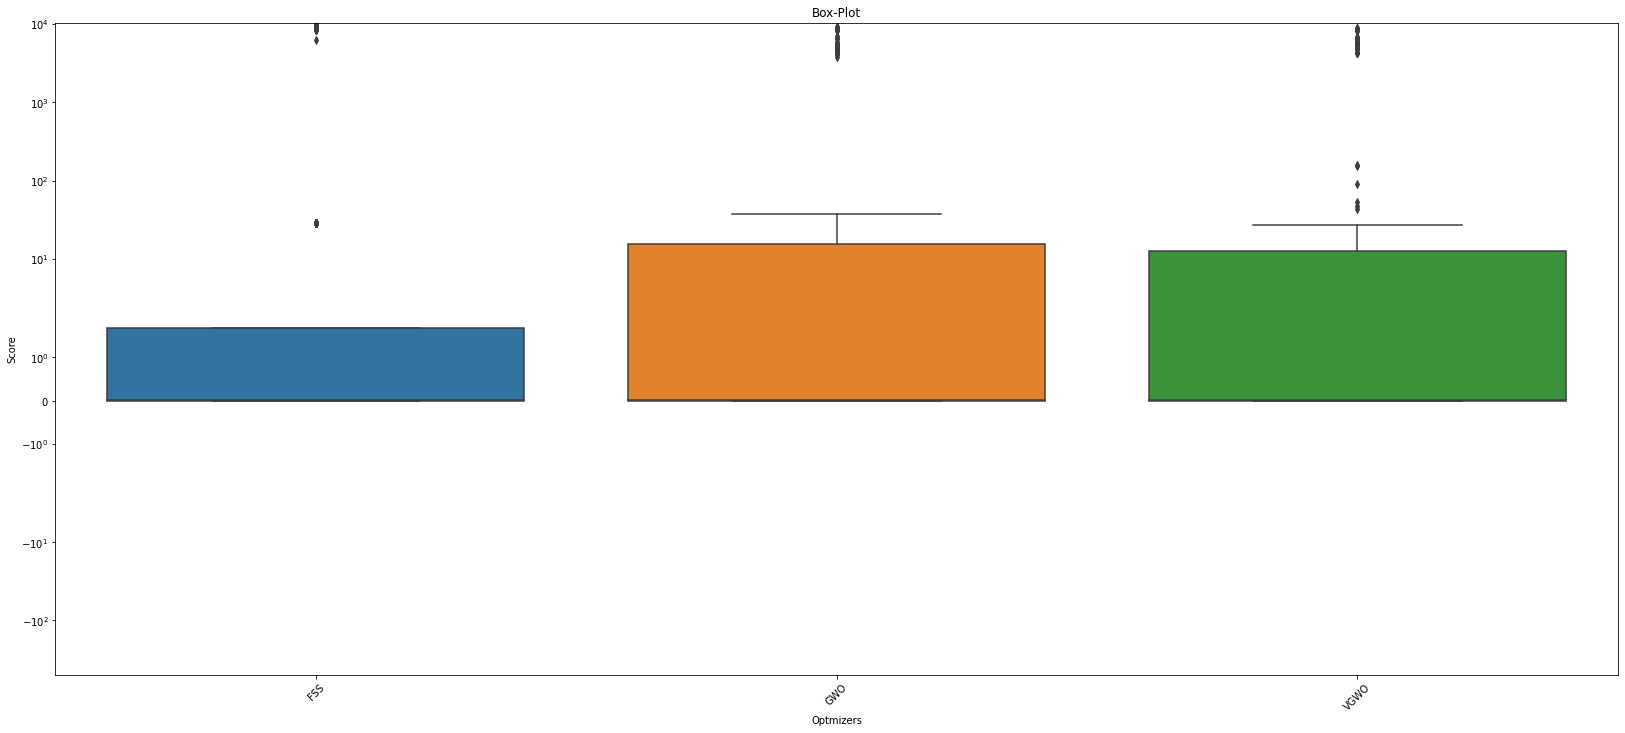

In [7]:
objective_functions = results[30]['func'].unique().tolist()
# objective_functions.remove('Levi-13')
# objective_functions.remove('Perm')
opts = results[30]['opt'].unique()
obj_show = []
for func in objective_functions:
  for o in opts[1:]:
    res = results[30][results[30]['func'] == func]
    res = res[res['opt'] == o].head(1)
    res = res.drop(['opt', 'func', 'exec_time'], axis=1)
    scores = res.values.tolist()[0]
    for s in scores:
      obj_show.append({'opt': o, 'score': s})
  
res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['opt', 'score'])
# res = res[res["score"] <= 100] # remove outliers
# res = res[res["score"] >= -1000]
ax = sns.boxplot(data=res, x='opt', y='score')
ax.set_yscale('symlog')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(xlabel= 'Optmizers', ylabel='Score', title='Box-Plot')

### Verification learning swarms in 10000 iterations

Now, for see the one execution, with 500 interation in the swarm to see the swarm evolution/learning me saved in differents files and show in graphics comparing every algoritms in the same iteration.

In [8]:
optimizers = ["PSO", "FSS", "GWO", "VGWO"]
files_100 = []
files_50 = []
files_30 = []
files_15 = []
filepath = os.path.dirname(os.path.abspath('Results'))
for opt in optimizers:
  filename = f"{filepath}/100d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_100.append(df)
  filename = f"{filepath}/50d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_50.append(df)
  filename = f"{filepath}/30d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_30.append(df)
  filename = f"{filepath}/15d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_15.append(df)

results_15 = pd.concat(files_15)
results_15.sort_values(by=['func'], ascending=False)
results_30 = pd.concat(files_30)
results_30.sort_values(by=['func'], ascending=False)
results_50 = pd.concat(files_50)
results_50.sort_values(by=['func'], ascending=False)
results_100 = pd.concat(files_100)
results_100.sort_values(by=['func'], ascending=False)
results = {15: results_15, 30: results_30, 50: results_50, 100: results_100}
results_30.head(5)

,opt,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run991,run992,run993,run994,run995,run996,run997,run998,run999,run1000
0,PSO,Sphere,3.388904,2.139500e+02,1.611658e+02,1.611658e+02,1.611658e+02,1.320692e+02,1.320692e+02,1.320692e+02,...,1.731079e-16,1.596939e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16
1,PSO,RotatedHyperEllipsoid,9.054343,4.751300e+05,3.176430e+05,2.596008e+05,2.596008e+05,2.596008e+05,2.564614e+05,2.239103e+05,...,8.193096e-12,8.193096e-12,7.714900e-12,7.704965e-12,7.704965e-12,7.150297e-12,7.150297e-12,7.090381e-12,6.466823e-12,5.549022e-12
2,PSO,Rosenbrock,3.913796,9.749288e+05,7.360942e+05,7.099939e+05,7.099939e+05,6.346845e+05,4.619173e+05,4.619173e+05,...,4.089024e+00,4.087465e+00,4.066577e+00,4.048552e+00,4.024244e+00,4.006816e+00,4.006816e+00,3.994629e+00,3.994629e+00,3.964825e+00
3,PSO,Dixon-Price,4.545007,8.730391e+06,5.519232e+06,5.315953e+06,5.315953e+06,5.315953e+06,3.478035e+06,3.471482e+06,...,7.870387e-03,6.524244e-03,6.524244e-03,6.524244e-03,6.524244e-03,5.558138e-03,5.558138e-03,5.558138e-03,5.558138e-03,5.260805e-03
4,PSO,Quartic-Noise,3.888588,9.739375e+01,7.652279e+01,7.542459e+01,7.542459e+01,7.430618e+01,6.147767e+01,6.147767e+01,...,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00


Functions w/ 15 dim


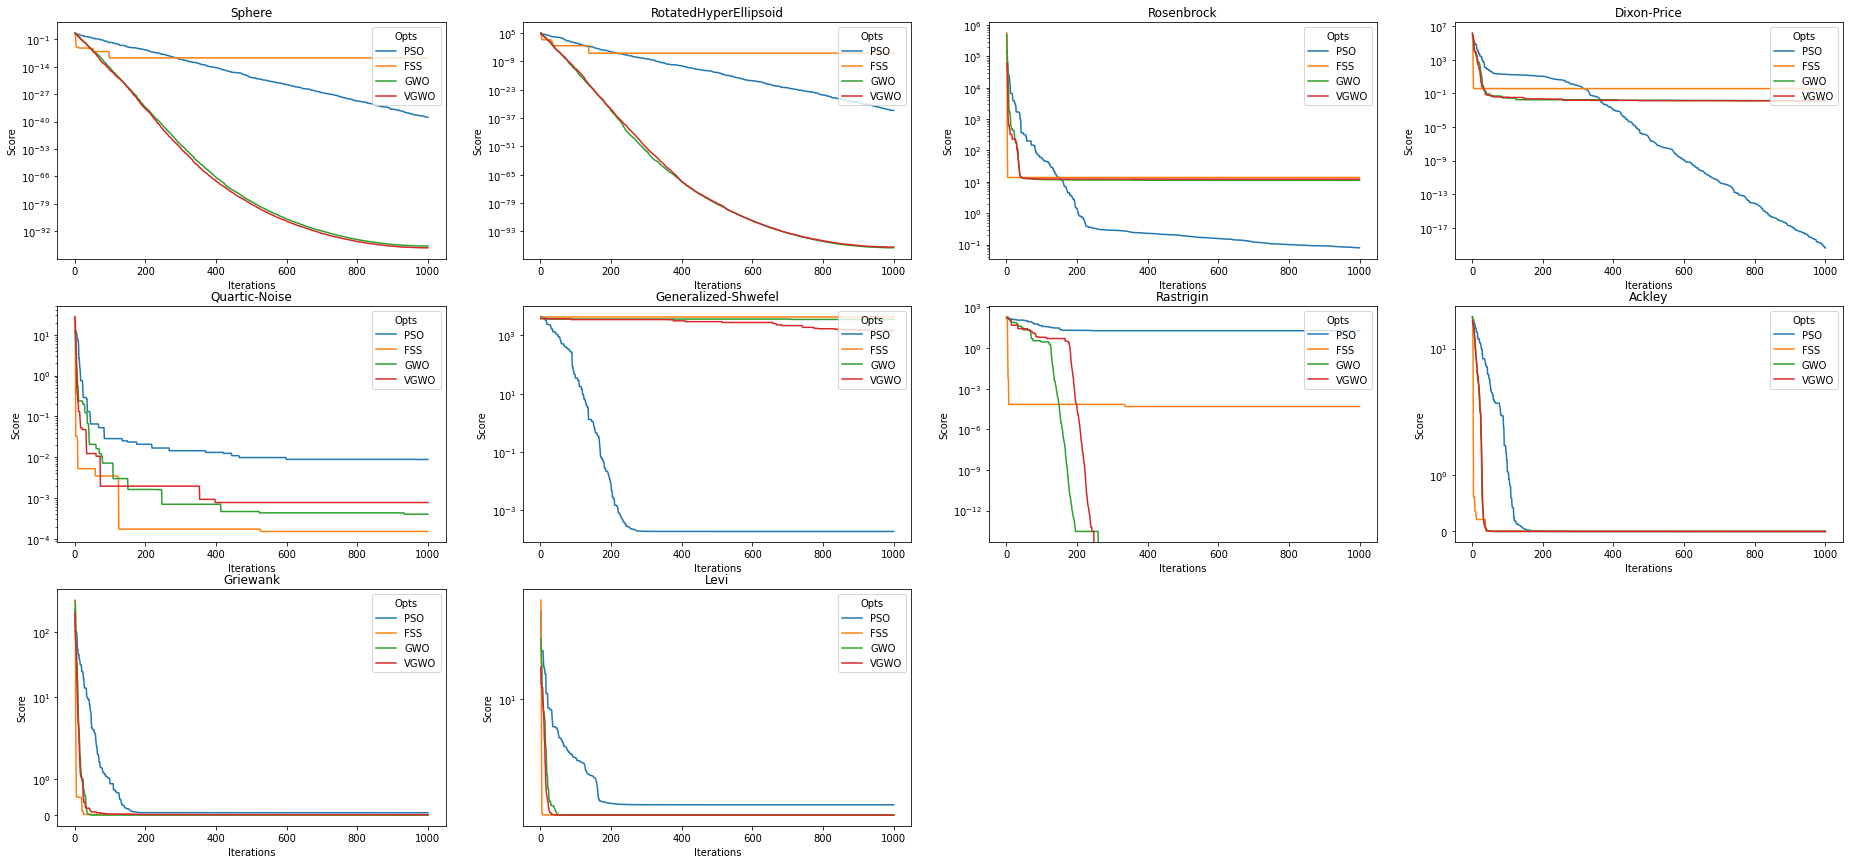

Functions w/ 30 dim


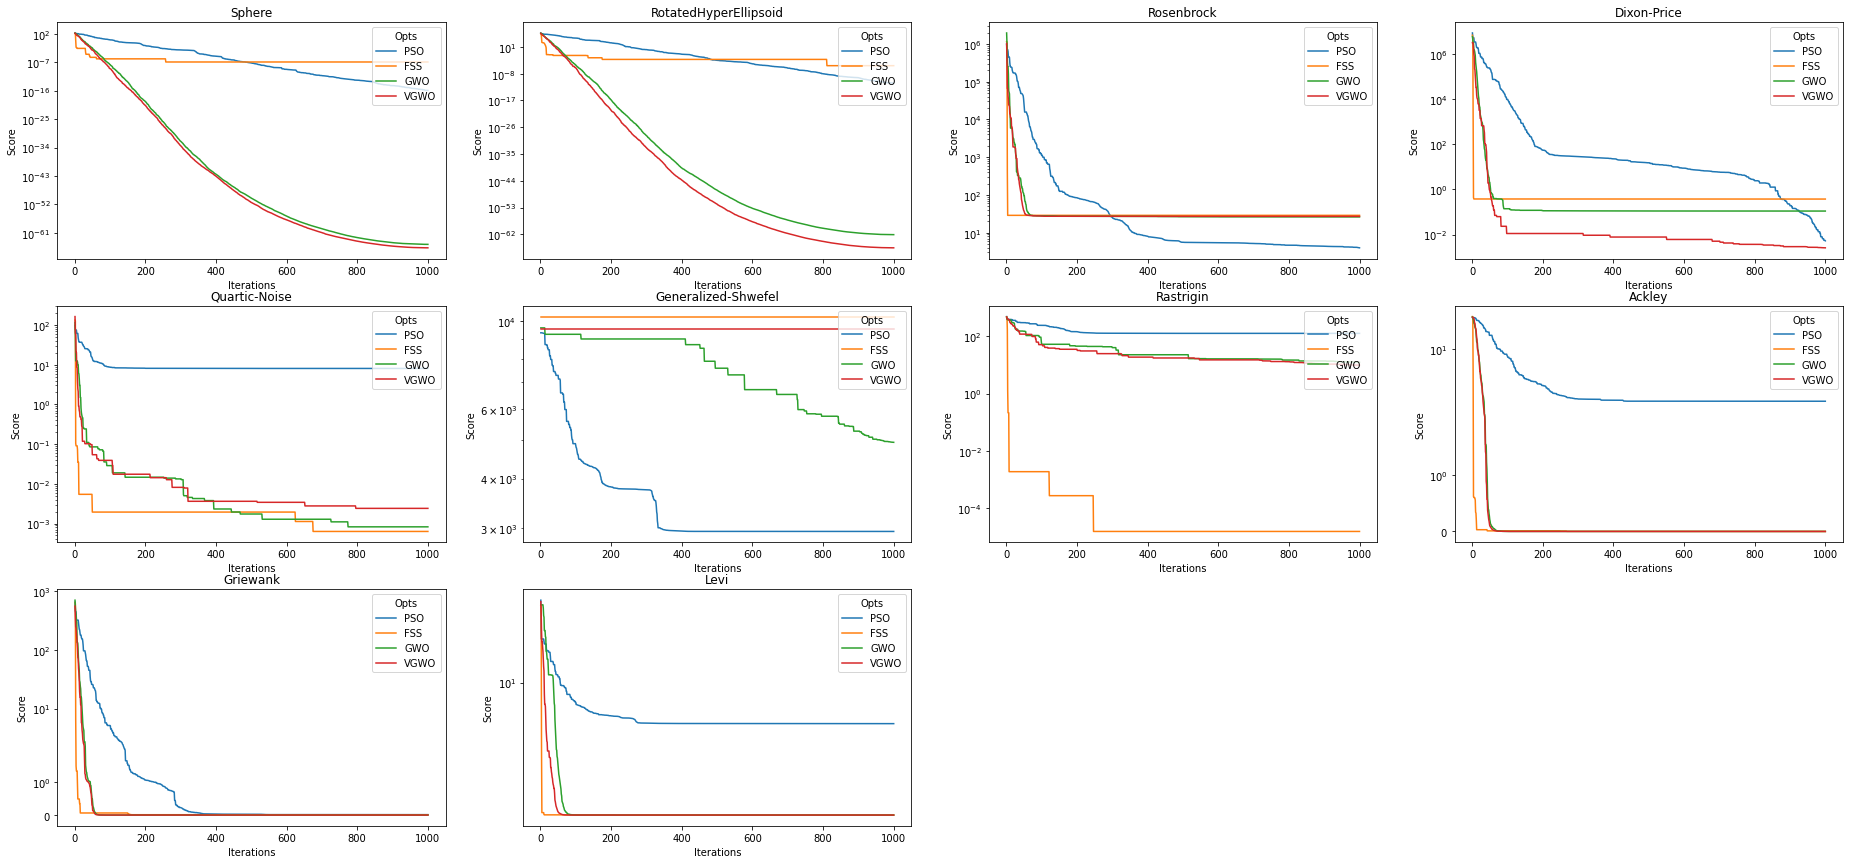

Functions w/ 50 dim


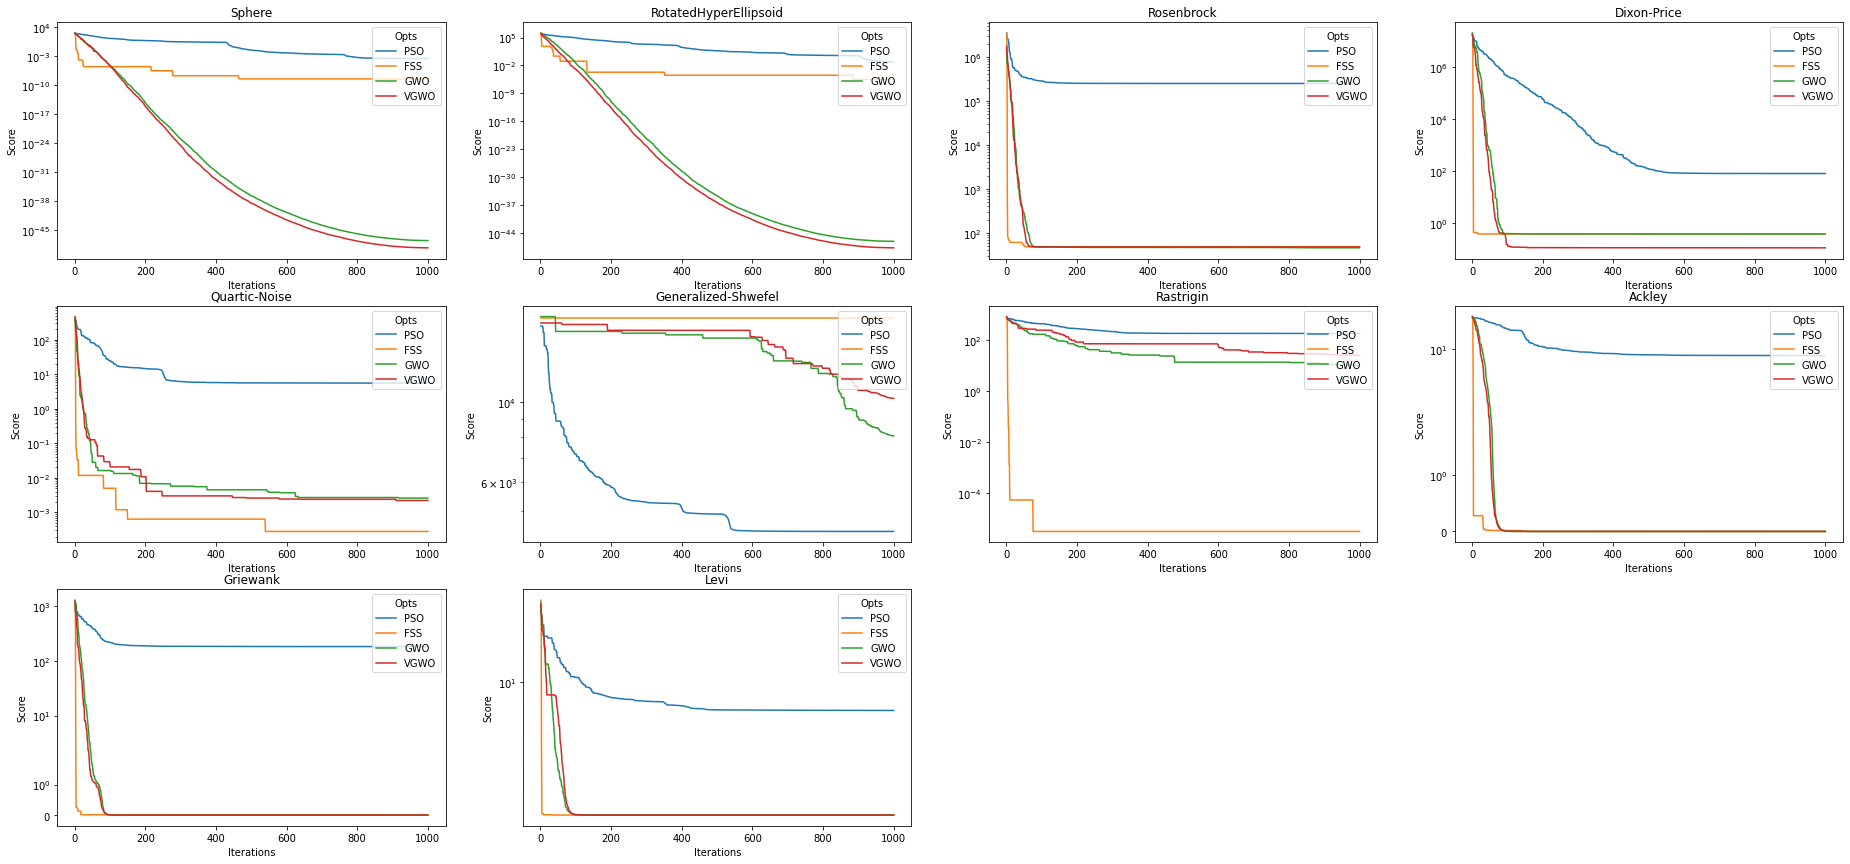

Functions w/ 100 dim


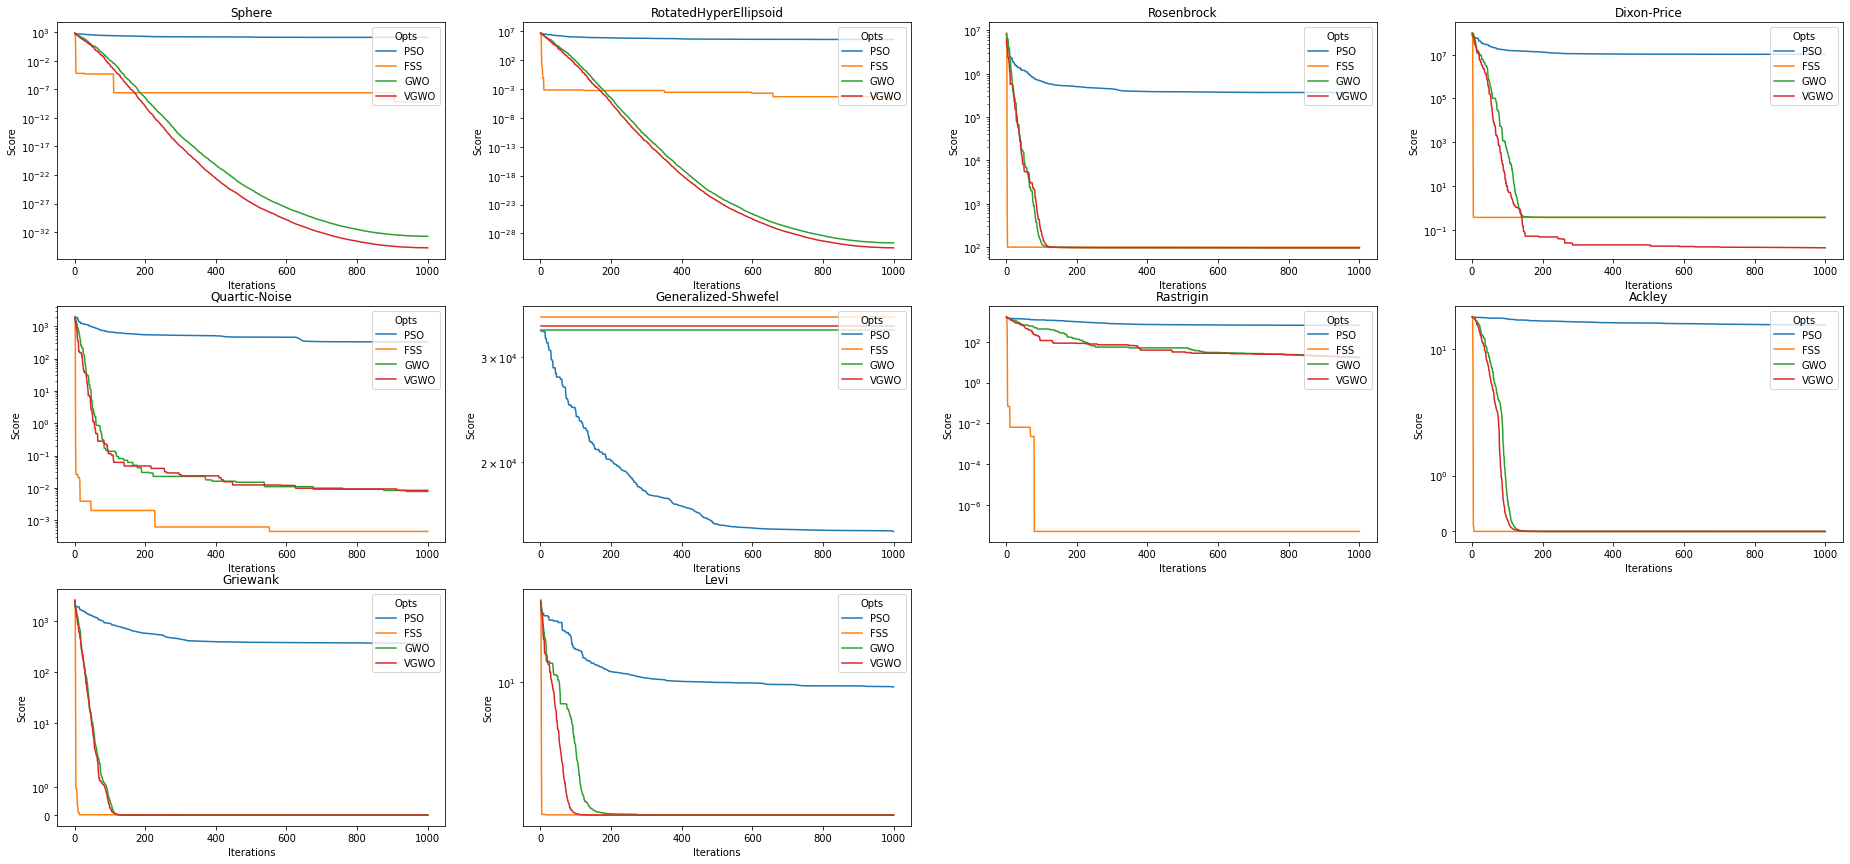

In [9]:
plt.rcParams["figure.figsize"] = (32,20)
for d in results:
  objective_functions = results[d]['func'].unique().tolist()
  # objective_functions.remove('Levi-13')
  # objective_functions.remove('Perm')
  opts = results[d]['opt'].unique()
  print(f"Functions w/ {d} dim")
  for i, func in enumerate(objective_functions):
    plt.subplot(4, 4, i+1)
    for o in opts:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == o].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      y = res.values.tolist()[0][:1000]
      min_y = np.inf
      new_y = []
      for v in y:
        if v < min_y:
          min_y = v
        new_y.append(min_y)
      y = new_y
      dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
      plt.plot(dt, label=o)
      plt.yscale('symlog' if i > 6 else 'log')
      plt.legend(loc='upper right', title="Opts")
    plt.title(func)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
  plt.show()

### Verification steps volutives (15 dim)

Validate fitness curve in 300 interations

In [10]:
steps = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
files = []
filepath = os.path.dirname(os.path.abspath('Results'))
for s in steps:
  filename = f"{filepath}/VGWO-vol/{s}-vol.csv"
  df = pd.read_csv(filename)
  files.append(df)

results = pd.concat(files)
results.sort_values(by=['func'], ascending=False)
results.head(5)

,step_vol,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run991,run992,run993,run994,run995,run996,run997,run998,run999,run1000
0,0.0001,Sphere,7.983411,68.501731,56.105312,45.795322,26.638148,22.583939,20.401332,11.612667,...,1.016294e-98,1.013835e-98,1.012404e-98,1.009960e-98,1.008461e-98,1.006610e-98,1.005452e-98,1.004741e-98,1.003710e-98,1.003631e-98
1,0.0001,RotatedHyperEllipsoid,5.969454,25851.956897,25851.956897,14329.286868,13956.226984,4885.470363,4532.082584,2195.236881,...,5.477494e-105,5.465678e-105,5.448448e-105,5.440795e-105,5.429550e-105,5.419622e-105,5.411942e-105,5.409283e-105,5.406973e-105,5.404723e-105
2,0.0001,Rosenbrock,3.212955,173487.315392,127664.963690,49981.231080,14408.051752,10658.546071,5748.526621,5748.526621,...,1.023881e+01,1.023881e+01,1.023648e+01,1.023511e+01,1.023292e+01,1.023287e+01,1.023161e+01,1.023040e+01,1.023006e+01,1.022970e+01
3,0.0001,Dixon-Price,3.287000,912739.941120,281678.983117,200643.449011,146638.776190,84179.050113,49484.600020,30454.471037,...,1.692536e-03,1.692536e-03,1.692536e-03,1.692536e-03,1.691363e-03,1.691363e-03,1.684470e-03,1.684470e-03,1.684470e-03,1.684100e-03
4,0.0001,Quartic-Noise,3.038926,13.773140,7.577981,3.714733,2.720809,2.693665,1.332142,0.881203,...,7.017565e-04,7.017565e-04,7.017565e-04,7.017565e-04,7.017565e-04,7.017565e-04,7.017565e-04,7.017565e-04,7.017565e-04,7.017565e-04


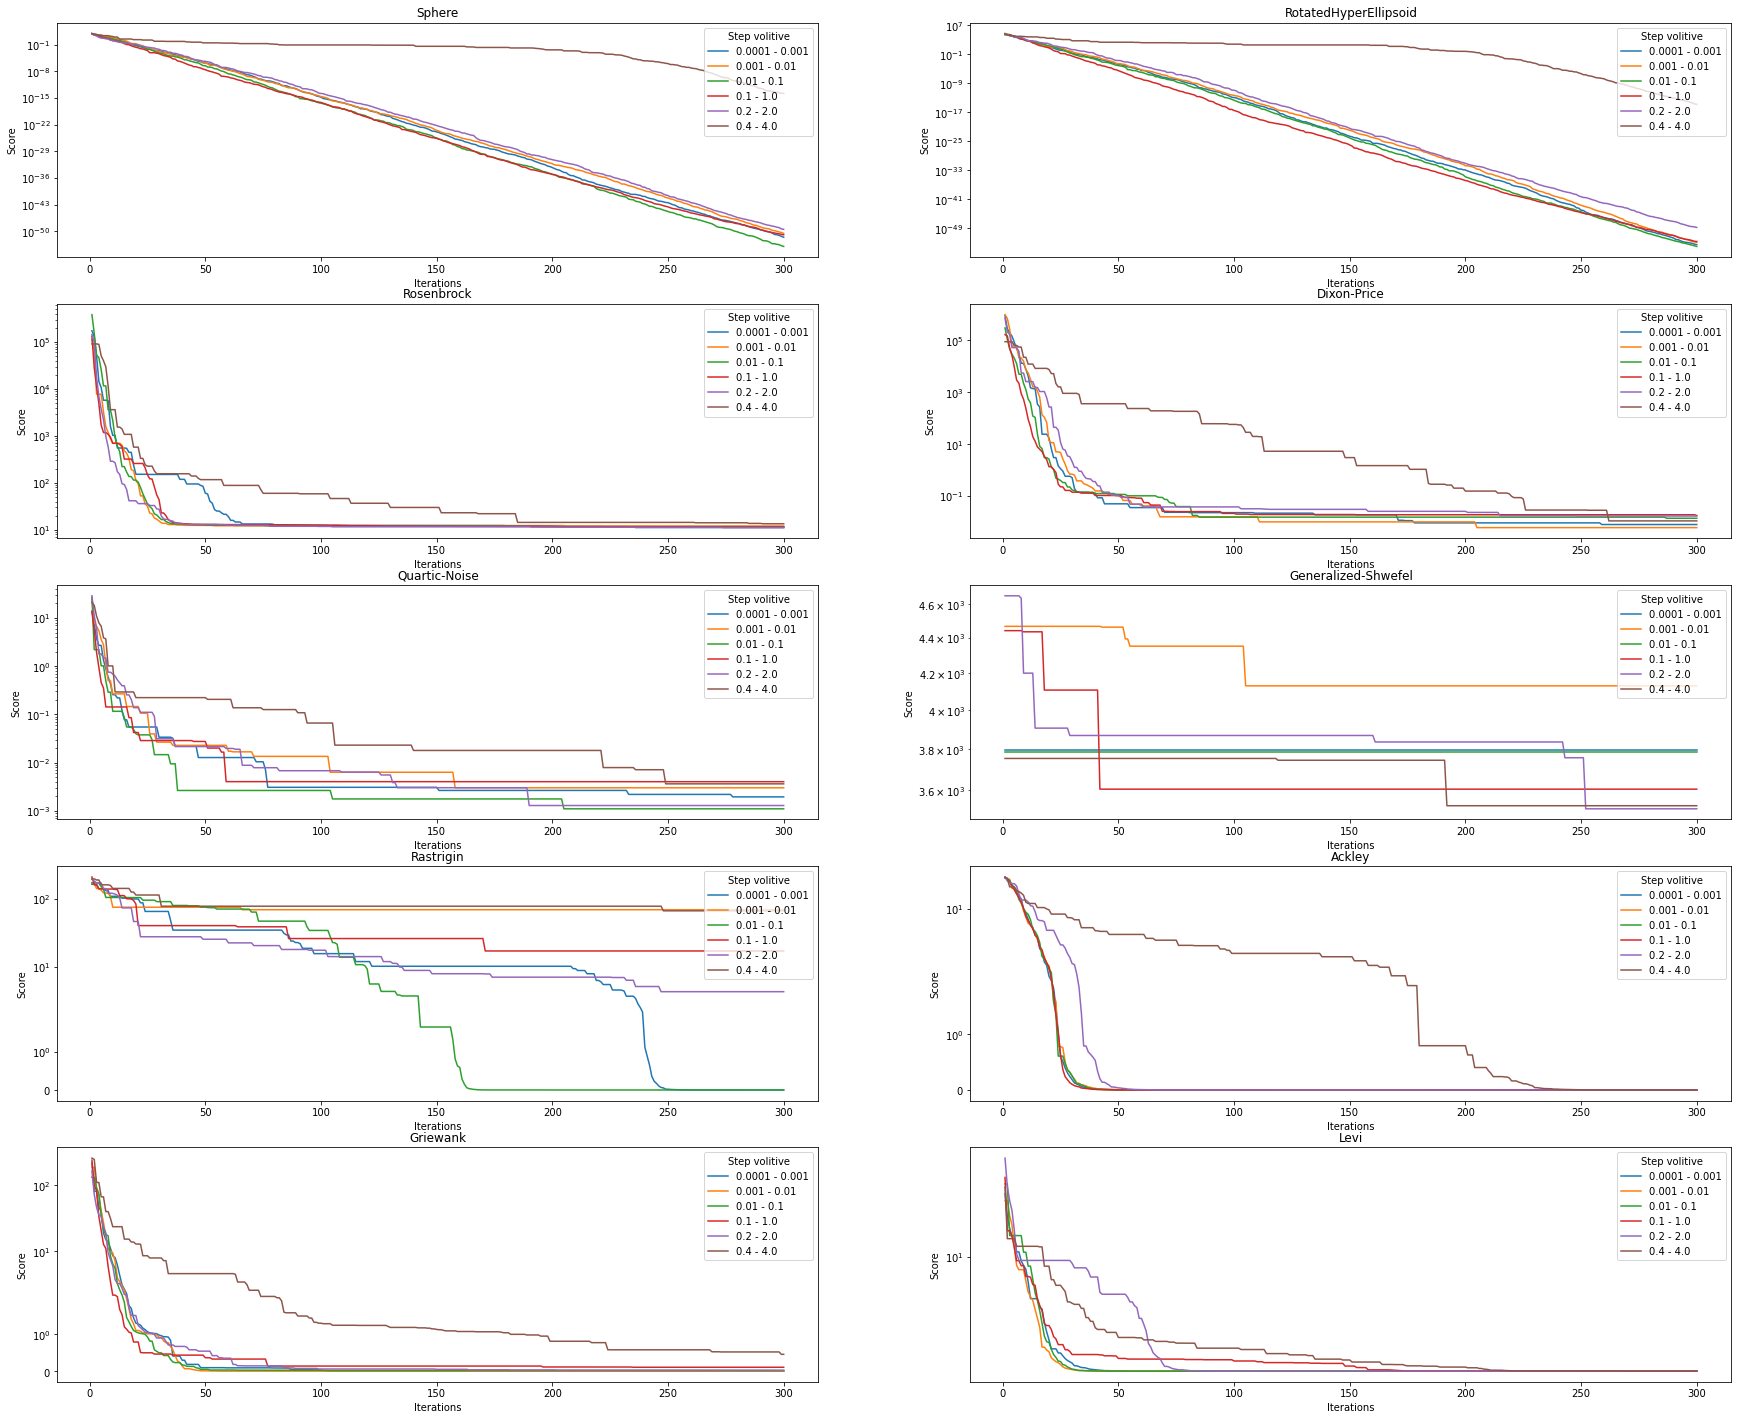

In [11]:
plt.rcParams["figure.figsize"] = (30,25)
objective_functions = results['func'].unique().tolist()
#objective_functions.remove('Levi-13')
#objective_functions.remove('Perm')
steps = results['step_vol'].unique()
for i, func in enumerate(objective_functions):
  # if func in ['Perm', 'Levi-13']:
  #   continue
  plt.subplot(5, 2, i+1)
  for s in steps:
    res = results[results['func'] == func]
    res = res[res['step_vol'] == s].head(1)
    res = res.drop(['step_vol', 'func', 'exec_time'], axis=1)
    y = res.values.tolist()[0][:300]
    min_y = np.inf
    new_y = []
    for v in y:
      if v < min_y:
        min_y = v
      new_y.append(min_y)
    y = new_y
    dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
    plt.plot(dt, label=f"{s} - {s*10}")
    plt.legend(loc='upper right', title='Step volitive')
    plt.yscale('symlog' if i > 5 else 'log')
  plt.title(func)
  plt.xlabel('Iterations')
  plt.ylabel('Score')
  # plt.text(0, 0, string.ascii_uppercase[i], size=20, weight='bold')
plt.show()

Validation fitness variance in 30 executions

In [12]:
steps = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
files = []
filepath = os.path.dirname(os.path.abspath('Results'))
for s in steps:
  filename = f"{filepath}/VGWO-vol/VGWO_exec_{s}.csv"
  df = pd.read_csv(filename)
  files.append(df)

results = pd.concat(files)
results.sort_values(by=['func'], ascending=False)
results.head(5)

,step_vol,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run21,run22,run23,run24,run25,run26,run27,run28,run29,run30
0,0.0001,Sphere,98.248754,3.139768e-102,4.228728e-102,1.255013e-98,2.042023e-102,3.995590e-101,1.331816e-100,2.170232e-103,...,9.211827e-102,3.017758e-104,5.060245e-100,1.541687e-98,1.147041e-97,7.802578e-100,5.222340e-100,6.852530e-101,1.267210e-101,2.740523e-100
1,0.0001,RotatedHyperEllipsoid,180.861334,3.351436e-104,7.032492e-97,1.372590e-101,5.784209e-102,2.771531e-101,2.376443e-100,7.507129e-102,...,7.377481e-99,7.643059e-102,3.226698e-102,8.888353e-103,3.644785e-102,1.617978e-99,3.596369e-102,1.553409e-101,1.075223e-101,7.626945e-103
2,0.0001,Rosenbrock,95.489143,1.213503e+01,1.053327e+01,1.106586e+01,1.112126e+01,1.076509e+01,1.118112e+01,1.215193e+01,...,1.119819e+01,1.097486e+01,1.001123e+01,1.117137e+01,1.116977e+01,9.879915e+00,1.038951e+01,1.113061e+01,1.111162e+01,1.111289e+01
3,0.0001,Dixon-Price,100.612971,1.970502e-03,1.047448e-03,1.473481e-02,1.444904e-02,1.384959e-03,1.354288e-02,1.100092e-01,...,1.393161e-02,2.033400e-03,1.371138e-02,1.577166e-03,9.970755e-03,6.786963e-03,8.868858e-04,1.410639e-02,1.341927e-03,1.330239e-02
4,0.0001,Quartic-Noise,90.835158,1.820013e-04,1.150348e-03,2.936968e-04,9.096388e-04,7.650318e-04,4.918558e-04,1.057214e-03,...,1.068860e-03,1.838999e-03,6.590164e-04,8.280575e-04,8.045355e-04,6.998004e-04,5.845443e-04,8.567731e-04,9.601501e-04,2.356578e-04


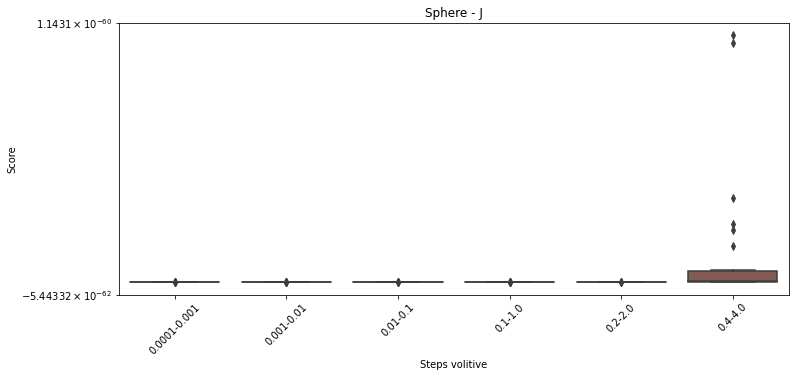

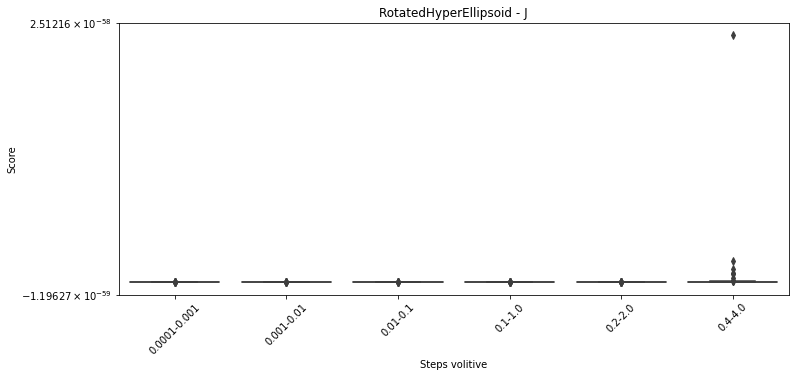

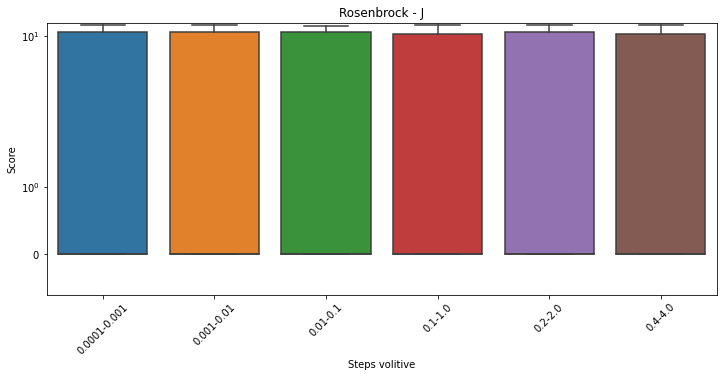

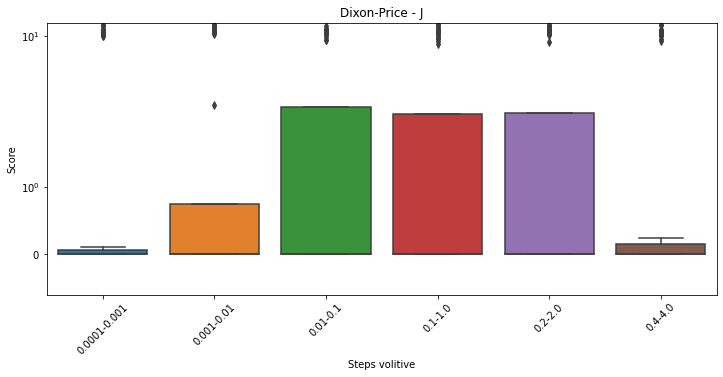

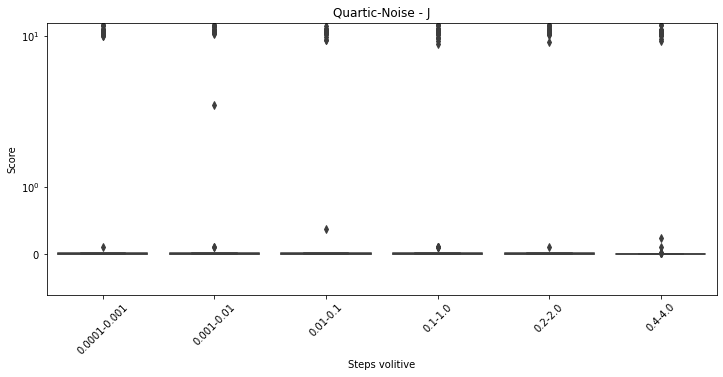

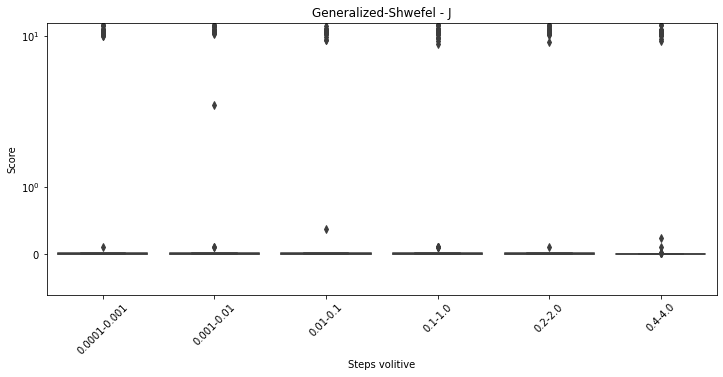

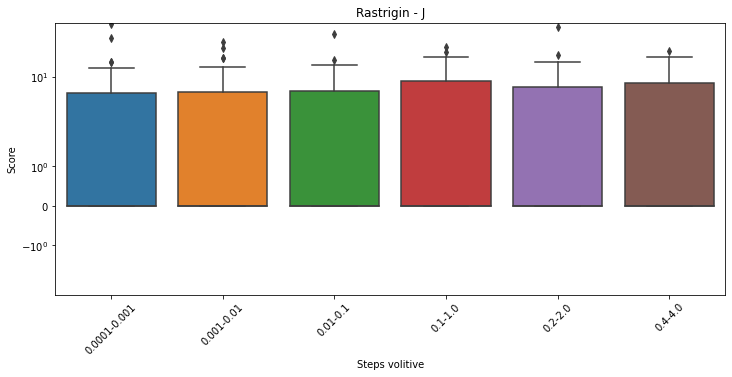

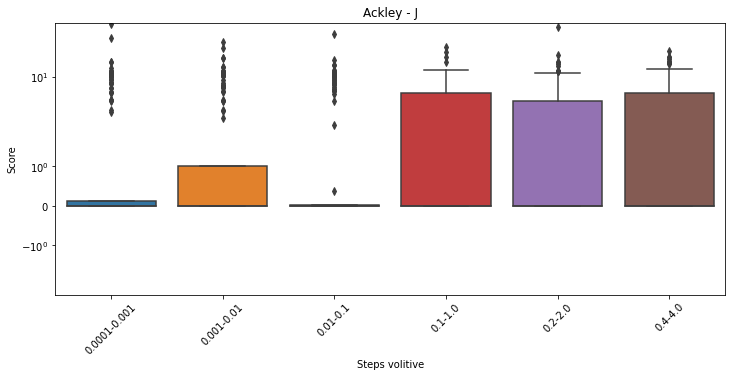

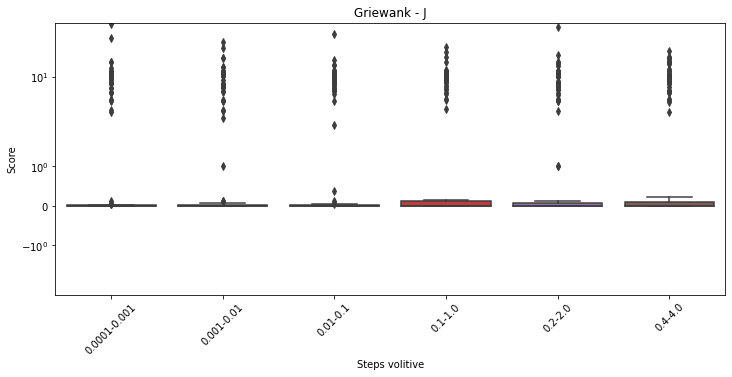

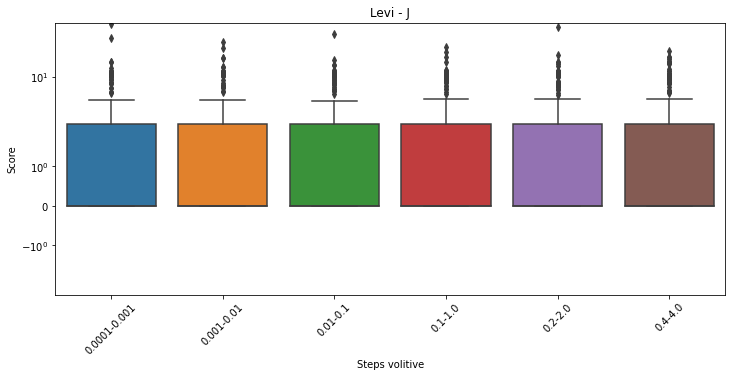

In [13]:
plt.rcParams["figure.figsize"] = (12,5)
tb_dt = {}
objective_functions = results['func'].unique().tolist()
# objective_functions.remove('Levi-13')
# objective_functions.remove('Perm')
steps_vol = results['step_vol'].unique()
obj_show = []
for func in objective_functions:
  tb_dt[func] = {}
  for v in steps_vol:
    res = results[results['func'] == func]
    res = res[res['step_vol'] == v].head(1)
    res = res.drop(['step_vol', 'func', 'exec_time'], axis=1)
    scores = res.values.tolist()[0]
    tb_dt[func][v] = scores
    for s in scores:
      obj_show.append({'step': f"{v}-{v*10}", 'score': s})
  
  res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['step', 'score'])
  res = res[res["score"] <= 60] # remove outliers
  # res = res[res["score"] >= -1000]
  ax = sns.boxplot(data=res, x='step', y='score')
  ax.set_yscale('symlog')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set(xlabel='Steps volitive', ylabel='Score', title=f"{func} - {string.ascii_uppercase[i]}")
  plt.show()

In [14]:
dt_func = []
for func in tb_dt:
  print(f"{func}")
  for v in tb_dt[func]:
    vols = list(tb_dt[func].keys())
    size_tb = len(tb_dt[func][v])
    lines = [[tb_dt[func][vol][i] for vol in vols] for i in range(size_tb)]
    dt = pd.DataFrame(data=lines, index=range(1, len(tb_dt[func][v])+1), columns=vols)
    dt_func.append(dt)

  # print(dt.describe())
  # print()
  display(dt.describe().loc[:].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))

Sphere


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


RotatedHyperEllipsoid


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Rosenbrock


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,12.962675,10.833430,10.832252,10.744910,11.047417,10.286365
std,10.637152,1.605697,0.612360,0.857482,0.701597,2.006293
min,9.879915,2.642932,9.188493,8.543933,8.763753,0.232426
25%,10.923041,10.843984,10.657850,10.445440,10.776696,10.275874
50%,11.117684,11.116786,11.066764,11.035494,11.118894,10.524230
75%,11.170973,11.179188,11.173563,11.165732,11.200402,10.999528
max,69.217009,12.148252,11.969948,12.136836,12.141095,12.130467


Dixon-Price


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.010838,0.012162,0.018386,0.023233,0.010794,0.006993
std,0.019696,0.027149,0.067628,0.039740,0.019054,0.020028
min,0.000597,0.000283,0.000435,0.000236,0.000209,0.000277
25%,0.001427,0.001140,0.001227,0.001648,0.001415,0.000907
50%,0.008379,0.001733,0.001955,0.002646,0.010454,0.001326
75%,0.013922,0.013678,0.013850,0.013993,0.013835,0.002239
max,0.110009,0.109914,0.375000,0.109925,0.106242,0.109843


Quartic-Noise


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000824,0.000911,0.001026,0.001064,0.000958,0.001627
std,0.000411,0.000621,0.000729,0.000718,0.000619,0.000840
min,0.000182,0.000143,0.000133,0.000152,0.000201,0.000254
25%,0.000515,0.000386,0.000524,0.000518,0.000576,0.001091
50%,0.000816,0.000720,0.000779,0.001013,0.000901,0.001458
75%,0.001050,0.001367,0.001411,0.001364,0.001232,0.001969
max,0.001839,0.002171,0.002866,0.003020,0.002742,0.003977


Generalized-Shwefel


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2687.880968,2373.802286,2399.804384,2615.363973,2355.306434,2207.121886
std,796.702677,538.046552,617.048221,805.159113,538.350749,702.403925
min,1449.057010,1231.502532,1237.621043,1226.861094,1443.094760,868.960426
25%,1939.103982,2068.007093,1892.900680,1957.122742,1944.792025,1799.124234
50%,2631.626154,2317.481787,2450.304411,2545.055353,2255.398307,2073.896180
75%,3469.555917,2709.541132,2800.611183,3096.423955,2586.228193,2639.106410
max,3917.647290,3667.713026,3440.241040,4031.326795,3844.468115,3486.869361


Rastrigin


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,8.587881,10.223050,9.218095,9.359759,12.080046,12.567654
std,11.256896,14.520507,15.439425,5.971152,18.819700,13.585410
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.276655,3.370806,0.000000,6.280839,4.800593,6.404725
50%,6.130365,7.097534,6.640587,9.170820,7.313719,9.030358
75%,9.318755,11.053315,9.023501,10.919473,10.468522,15.497806
max,55.001478,75.797673,79.028046,26.817790,98.698134,78.433763


Ackley


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Griewank


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.010796,0.015580,0.018409,0.030034,0.018543,0.034863
std,0.018058,0.023022,0.025202,0.034097,0.027432,0.029127
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.009619,0.000000,0.013847
50%,0.000000,0.000000,0.012740,0.020285,0.010272,0.023128
75%,0.015551,0.022931,0.022032,0.038164,0.022835,0.054393
max,0.057430,0.097433,0.113666,0.139643,0.113243,0.101668


Levi


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.220219,2.166437,2.203484,2.238692,2.161795,2.260747
std,0.244447,0.036105,0.135579,0.157156,0.010680,0.331114
min,2.159845,2.159845,2.159845,2.159845,2.159845,2.159845
25%,2.159845,2.159845,2.159845,2.159845,2.159845,2.159845
50%,2.159845,2.159845,2.159845,2.159845,2.159845,2.159845
75%,2.159845,2.159845,2.159845,2.203589,2.159845,2.159845
max,3.383228,2.357602,2.708326,2.686267,2.218341,3.858157
